In [1]:
import numpy as np
import pandas as pd
import copy
import readDatasets as rd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', None)
pd.set_option('colheader_justify', 'center')

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.metrics import accuracy_score, r2_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Paso 0: Explicación del proyecto

Los videojuegos, como cualquier otro medio de entretenimiento, tienen sus propias características que los diferencian unos de otros. Ya sea por ejemplo su genero o la valoración que le han dado los usuarios y expertos. Mediante este trabajo, intentaremos realizar un recomendador de una manera sencilla. Para ello realizaremos 3 tipos de predictores distintos:

- **Clasificador Reviews** ➞ Dando un review escrita por nosotros como _input_, daremos una valoración como resultado.
- **Clasificador ESRBs** ➞ Mediante una serie de características, obtendremos el _rating_ ESRB que se le asocia a las mismas.
- **Recomendador Juegos** ➞ Como bien hemos mencionado, el paso final sera juntar estos dos predictores con uno nuevo y dar como resultado el o los juegos que más se asemejen a nuestras preferencias.

# Paso 1: Lectura de los datos
Lo primero de todo a realizar es una lectura de datos que se encuentran en los archivos ".csv". Existen 2 archivos distinos:

- metacritic_**games**.csv ➞ En este fichero se encuentran todos los **datos** de los distintos juegos.
- metacritic_**reviews**.csv ➞ En este fichero se encuentran todas las **reviews** de los distintos juegos.

Por otro lado, existen dos ficheros con el mismo nombre, lo único que cambia es la terminación de los mismos. Los archivos **sin** terminación, y los archivos **con** terminación **master.csv**.

Como hemos mencionado, lo primero es leer los datos. Para ello lo que vamos a hacer es construir un diccionario que contenga todos los datos de cada juego. El diccionario se define de la siguiente forma:

`listaJuegos` = {**key** = _nombreJuego_, **value** = _caracteristicas_}

El valor que guarda el diccionario, de nombre _caracteristicas_ es un objeto llamado `juego` cuyas variables son las siguientes:

- **nombre** ➞ (STR) El nombre del juego.
- **fechaSalida** ➞ (INT) El año de salida del juego.
- **genero** ➞ (STR) El genero principal al que pertenece el juego.
- **plataforma** ➞ (ARRAY OF STR) Las plataformas donde fueron lanzadas las distintas versiones del mismo juego.
- **portable** ➞ (BINARIO) Si el juego se juega de manera portable o no.
- **desarrollador** ➞ (STR) La desarrolladora del juego.
- **esrb** ➞ Esto se trata de otro objeto distinto llamado `esrb` que posee las siguientes características:
    - **rating** ➞ (STR) El rating (_E_,_T_,_M_,...) del juego.
    - **caracteristicas** ➞ (ARRAY OF BINARIO) Las distintas características que cumple el juego para obtener el rating dado.
- **metaScore** ➞ (INT) La puntuación dada por profesionales.
- **userScore** ➞ (INT) La puntuación dada por los usuarios.
- **multijugador** ➞ (BINARIO) Si el juego tiene opción de poder ser jugado de manera multijugador.
- **online** ➞ (BINARIO) Si el juego tiene la posibilidad de jugar en linea.
- **sinopsis** ➞ (STR) El resumen principal del juego.
- **reviews** ➞ (ARRAY OF REVIEWS) Una matriz donde cada fila representa una reseña de cada juego. La columna 0 es la valoración dada y la columna 1 es el texto.

In [2]:
'''
Tiempo ejecucion celda aproximadamente 2 minutos
'''
# Establecemos la ruta de los archivos normales y master
fileGame = 'datos/' + 'metacritic_games'
fileReview = 'datos/' + 'metacritic_reviews'
# Leemos los datos con rd.lectura Datos
listaJuegos = rd.lecturaDatos(fileGame+'.csv',fileReview+'.csv')
listaJuegos = rd.lecturaDatos(fileGame+'_master.csv',fileReview+'_master.csv',listaJuegos)

del fileGame,fileReview

print("Ejemplos totales leidos en TOTAL: {}".format(len(listaJuegos)))

Ejemplos totales leidos en TOTAL: 5424


Hemos obtenido finalmente **5424** juegos distintos de la combinación de los conjuntos _normal_ y _master_. Lo primero de todo es sacar de aquí las particiones de datos en _train_ y _test_.

In [3]:
from sklearn.model_selection import train_test_split as split

#Creamos una 'serie' donde guardamos todos los datos del diccionario original y asi poder realizar la partición
datosTrainTest = pd.Series(listaJuegos)
listaJuegosTrain, listaJuegosTest = split([i.to_dict() for i in split(datosTrainTest,train_size=0.85,random_state=42)],shuffle=True,random_state=42)
listaJuegosTrain = listaJuegosTrain[0]
listaJuegosTest = listaJuegosTest[0]

#Borramos la variable innecesaria
del datosTrainTest

print("Cantidad de juegos en el conjunto TRAIN: {}  //  TEST: {}".format(len(listaJuegosTrain),len(listaJuegosTest)))

Cantidad de juegos en el conjunto TRAIN: 4610  //  TEST: 814


Así pues, los datos quedan divididos de la siguente forma:

- `listaJuegosTrain` un _84,99%_ del total
- `listaJuegosTest` un _15.01%_ del total

Crearemos ahora dos diccionarios distintos, donde guardaremos los predictores que se usen para su propio trabajo, asi como su _accuracy_. Siendo:

- **Elemento 1** ➞ El objecto _predictor_
- **Elemento 2** ➞ El _accuracy_ del mismo

In [4]:
mejorClasificadorESRB = {'regresionLineal': np.zeros((2),dtype=object), 'regresionLogistica': np.zeros((2),dtype=object), 'nb': np.zeros((2),dtype=object),
                        'redNeuronal': np.zeros((2),dtype=object), 'svm': np.zeros((2),dtype=object), 'decisionTree': np.zeros((2),dtype=object),
                        'adaboost': np.zeros((2),dtype=object),'bagging': np.zeros((2),dtype=object), 'randomForest': np.zeros((2),dtype=object), 
                        'ova': np.zeros((2),dtype=object), 'ovo': np.zeros((2),dtype=object), 'kmeans': np.zeros((2),dtype=object)}

mejorClasificadorReviews = {'vectorizer': None, 'tfid': None, 'multiNBCount': np.zeros((2),dtype=object), 'multiNBTfid': np.zeros((2),dtype=object)}

# Paso 2: Clasificador ESRBs

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, learning_curve, StratifiedKFold

La primera gran parte del proyecto consiste en un clasificador de ESRB. El ESRB, o por sus siglas en inglés _Entertainment Software Rating_ _Board_, es el sistema estadounidense por el cual se clasifican los videojuegos para públicos de distintas edades.

Nuestro cometido en este paso es conseguir un predictor fiable que, dada una serie de características ESRB, como pueden ser la violencia, la presencia de juegos de azar o la sangre, nos devuelva la clasificación por edades más cercana a estas.

Los datos sobre los que vamos a trabajar se encuentran en los objetos `esrb` incluidos dentro de cada uno de los juegos.

## Preprocesamiento datos

Como datos _X_ usaremos las características ESRBs, las cuales son números **binarios**, sease 1 o 0 si se encuentran presentes o no. Y como datos _y_ usaremos la propia clasificación en si.

In [6]:
#Train
dictToList = np.array([*dict(list(listaJuegosTrain.items())).values()])  #Lista con todos los juegos de train
listOfCaracteristicas_train = []
listOfRatings_train = []
#Itero sobre la lista para extraer los arrays de características (X) y de ratings (Y)
for i in range(len(dictToList)): 
    listOfCaracteristicas_train.append(dictToList[i].esrb.caracteristicas)
    listOfRatings_train.append(dictToList[i].esrb.rating)

listOfCaracteristicas_train = np.array(listOfCaracteristicas_train)
listOfRatings_train = np.array(listOfRatings_train)

#Test
dictToList = np.array([*dict(list(listaJuegosTest.items())).values()])  #Lista con todos los juegos de test
listOfCaracteristicas_test = []
listOfRatings_test = []
#Itero sobre la lista para extraer los arrays de características (X) y de ratings (Y)
for i in range(len(dictToList)): 
    listOfCaracteristicas_test.append(dictToList[i].esrb.caracteristicas)
    listOfRatings_test.append(dictToList[i].esrb.rating)

listOfCaracteristicas_test = np.array(listOfCaracteristicas_test)
listOfRatings_test = np.array(listOfRatings_test)

print('Tras la lectura de nuestros datos, sabemos que tenemos {} clases distintas para predecir.'.format(np.unique(np.append(listOfRatings_train,listOfRatings_test))))

Tras la lectura de nuestros datos, sabemos que tenemos ['AO' 'E' 'E10+' 'K-A' 'M' 'RP' 'T'] clases distintas para predecir.


Tras la lectura de nuestros datos, sabemos que tenemos ['AO' 'E' 'E10+' 'K-A' 'M' 'RP' 'T'] clases distintas para predecir.

Observamos que tenemos 7 clases distintas para nuestro problema. No obstante, el dataset que hemos utilizado está ligeramente desfasado, pues la clasificación 'K-A' (_kids to adults_) es la ahora denominada 'E' (_everyone_). Hacemos un pequeño tratamiento a continuación para solventar este problema. Lo mismo ocurre con la clasificación 'AO' transformándola en 'M'

Por otro lado, es importante eliminar aquellos juegos cuyas características sean 'RP', ya que siginifican _Rate Pending_, por lo cual no tienen ningun valor asociado.

In [7]:
listOfRatings_train[listOfRatings_train == 'K-A'] = 'E'
listOfRatings_test[listOfRatings_test == 'K-A'] = 'E'
listOfRatings_train[listOfRatings_train == 'AO'] = 'M'
listOfRatings_test[listOfRatings_test == 'AO'] = 'M'

listOfCaracteristicas_train = np.delete(listOfCaracteristicas_train, listOfRatings_train=='RP',axis=0)
listOfCaracteristicas_test = np.delete(listOfCaracteristicas_test, listOfRatings_test=='RP',axis=0)

listOfRatings_train = np.delete(listOfRatings_train, listOfRatings_train=='RP')
listOfRatings_test = np.delete(listOfRatings_test, listOfRatings_test=='RP')

class_names = ['E','E10+','T','M']

print('Tras el tratamiento de nuestros datos, sabemos que tenemos {} clases distintas para predecir.'.format(class_names))

Tras el tratamiento de nuestros datos, sabemos que tenemos ['E', 'E10+', 'T', 'M'] clases distintas para predecir.


Finalmente, obtenemos 4 tipos de variables distintas, estas son:
- **E** ➞ Everyone
- **E10+** ➞ Everyone 10 years older
- **T** ➞ Teen
- **M** ➞ Mature

Una vez obtenidos y ajustados todos los datos que vamos a utilizar en el aprendizaje de los diversos modelos, necesitamos realizar un preprocesamiento. Este consistirá en dos partes distintas:

- **Estandarización de los datos** ➞ Mediante esto conseguiremos unos datos que se encuentren en mismos rangos, eliminando ruido y otros posibles inconvenientes.
- **PCA** ➞ Mediante esto, realizaremos una decomposición de dimensiones para poder mostrar donde se encuentran los datos. Reduciendo la dimensionalidad de los vectores en más de un 90% en algunos casos, con una pérdida mínima de información.

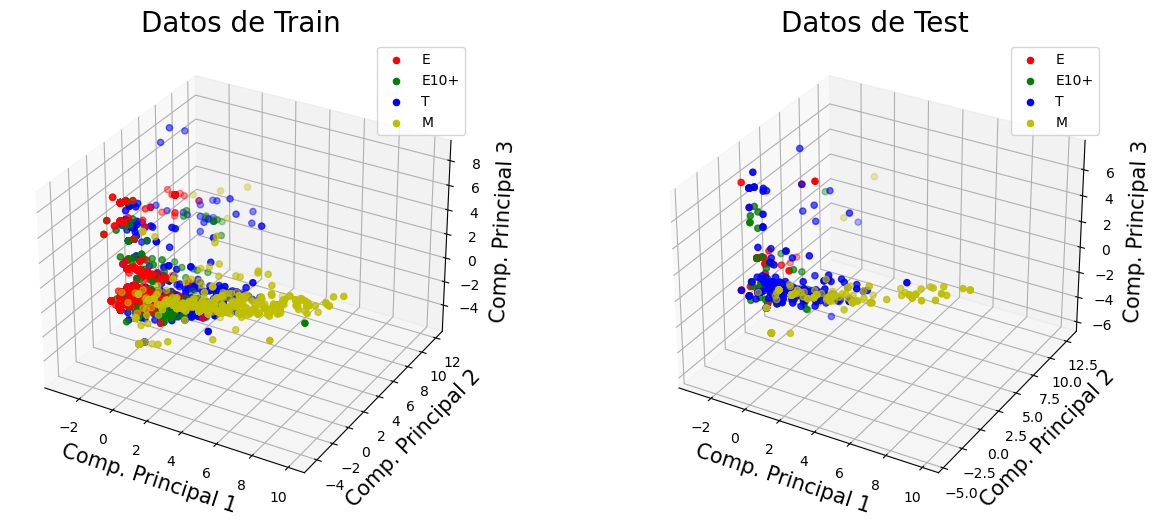

In [8]:
#Realizamos una estandarización de los datos
scESRB = StandardScaler()
listOfCaracteristicas_train = scESRB.fit_transform(listOfCaracteristicas_train)
listOfCaracteristicas_test = scESRB.transform(listOfCaracteristicas_test)

#Realizamos la reducción de dimensionalidad de los datos
pcaESRB = PCA(n_components=3)       
listOfCaracteristicas_train = pcaESRB.fit_transform(listOfCaracteristicas_train)
listOfCaracteristicas_test = pcaESRB.transform(listOfCaracteristicas_test)

#De aquí hasta acabar la celda realizaremos una serie de pasos para mostrar los datos procesados en forma gráfica
dfCaracteristicasTrain = pd.DataFrame(data = listOfCaracteristicas_train,columns = ["pc1", "pc2","pc3"])
dfCaracteristicasTest = pd.DataFrame(data = listOfCaracteristicas_test,columns = ["pc1", "pc2","pc3"])

dfRatingTrain = pd.DataFrame(data=listOfRatings_train,columns=["esrb_rating"])
dfRatingTest = pd.DataFrame(data=listOfRatings_test,columns=["esrb_rating"])

dfTrain = pd.concat([dfCaracteristicasTrain, dfRatingTrain], axis = 1)
dfTest = pd.concat([dfCaracteristicasTest, dfRatingTest], axis = 1)

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
targets = ["E", "E10+", "T", "M"]
colors = ["r", "g", "b", "y"]

ax1.set_xlabel("Comp. Principal 1", fontsize = 15)
ax1.set_ylabel("Comp. Principal 2", fontsize = 15)
ax1.set_zlabel("Comp. Principal 3", fontsize = 15)
ax1.set_title("Datos de Train", fontsize = 20)
for target, color in zip(targets,colors):
    indicesToKeep = dfRatingTrain == target
    ax1.scatter(dfTrain.loc[indicesToKeep['esrb_rating'], "pc1"], dfTrain.loc[indicesToKeep['esrb_rating'], "pc2"], dfTrain.loc[indicesToKeep['esrb_rating'], "pc3"],c = color)
ax1.legend(targets)
ax1.grid()

ax2.set_xlabel("Comp. Principal 1", fontsize = 15)
ax2.set_ylabel("Comp. Principal 2", fontsize = 15)
ax2.set_zlabel("Comp. Principal 3", fontsize = 15)
ax2.set_title("Datos de Test", fontsize = 20)
for target, color in zip(targets,colors):
    indicesToKeep = dfRatingTest == target
    ax2.scatter(dfTest.loc[indicesToKeep['esrb_rating'], "pc1"], dfTest.loc[indicesToKeep['esrb_rating'], "pc2"], dfTest.loc[indicesToKeep['esrb_rating'], "pc3"],c = color)
ax2.legend(targets)
ax2.grid()

De los datos observados, se pueden extraer varias conclusiones:

- Tanto los _ratings_ **M** y **E** son los que más "separados" se encuentran uno de otro, natural teniendo en cuenta la típica diferencia entre extremos.
- Por otro lado, y contrario a lo que hemos mencionado en el punto anterior, los datos de los otros dos _ratings_, **E10+** y **E**, se encuentran MUY mezclados. Esto tendrá efectos más o menos relevantes en los distintos clasificadores que utilicemos.

Una vez que todos los datos a usar se encuentran preprocesados, es importante mencionar el método que se va a seguir en todos los predictores.

1. Se usara el algoritmo `GridSearchCV` para obtener los mejores hiperparámetros de nuestros predictores.
    - A raiz de esto, usaremos `StratifiedKFold` para dividir los datos entre _train_ y _validación_. Mediante este algoritmo conseguiremos tener siempre datos de todas las clases en ambos conjuntos y no repetirlos en ninguna iteración, así como un correcto valance de estos.
2. Como soluciones finales, además de mostrar la precisión obtenida, tenemos 3 datos extras:
    - **Matriz de evaluación de modelos** ➞ Mostramos diversas características sobre cada clase respecto al predictor (Nos fijaremos en el atributo _accuracy-score_, la explicación a esto se contará al final de la sección).
    - **Curva de aprendizaje** ➞ Mostrar una curva de aprendizaje donde analizaremos el porcentaje de acierto en cada iteración.
    - **Matriz de confusión** ➞ Mostrar de manera más visual los _ratings_ acertados de manera correcta y los fallados.

Importante mencionar que algunos modelos no aceptan clases a clasificar como strings (_E_,_M_,...). Por lo que para ello hemos realizado un proceso mediante la función `LabelEncoder` mediante la cual transformamos esas etiquetas en valores [0, n-1] respecto a sus etiquetas originales.

In [9]:
from sklearn.preprocessing import LabelEncoder

leEsrb = LabelEncoder().fit(class_names)
listOfRatings_trainLE = leEsrb.transform(listOfRatings_train)
listOfRatings_testLE = leEsrb.transform(listOfRatings_test)

## Modelo 1: Regresión lineal
Una primera aproximación para la predicción puede ser usando una regresión lineal. Lo que hacemos es predecir la "tendencia" de los vectores. En ese caso, pueden tender hacia las distintas clasificaciones disponibles ['E' 'E10+' 'T' 'M']. En realidad, una regresión lineal no es un modelo correcto para este tipo de problema, que salta a la vista que se trata de uno de clasificación. No obstante, se empieza por aquí para obtener unos datos preliminares de los resultados, así como las tendencias de fallo y acierto de nuestros modelos.

LinearRegression(n_jobs=-1)

Results on the test set:
              precision    recall  f1-score   support

           0       0.29      0.03      0.06       223
           1       0.13      0.70      0.21       104
           2       0.39      0.50      0.44       151
           3       0.40      0.02      0.03       336

    accuracy                           0.20       814
   macro avg       0.30      0.31      0.19       814
weighted avg       0.33      0.20      0.14       814

ACCURACY OBTENIDO 0.19901719901719903


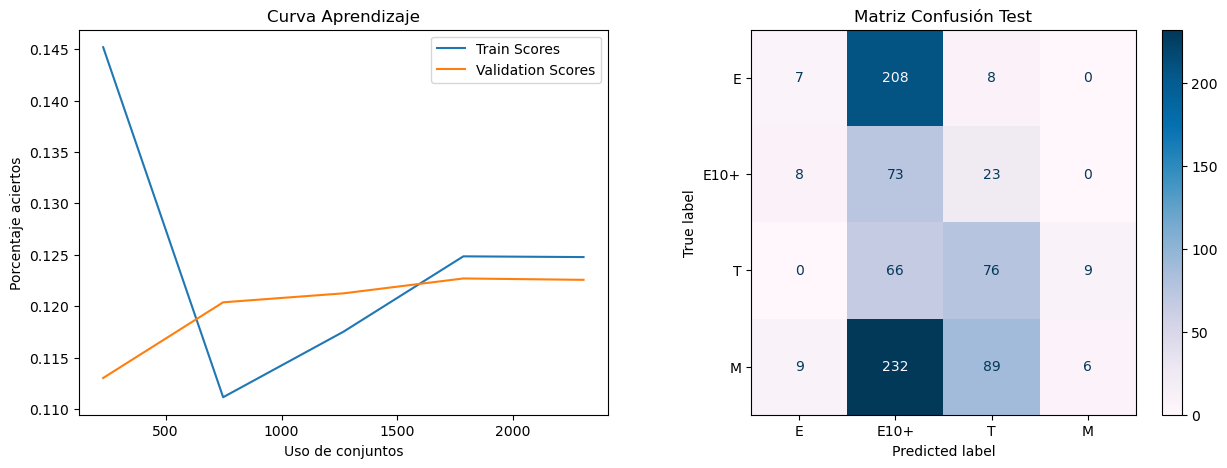

In [10]:
'''
REGRESIÓN LINEAL DE N VARIABLES
'''
#Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente a la regresión lineal
from sklearn.linear_model import LinearRegression

# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'fit_intercept': [True,False],
    'copy_X': [True,False],
    'n_jobs': [-1, 1, 10],
    'positive': [True, False],
}

# Genera el objeto StratifiedKFold para generar un particionamiento de datos en grupos
ss = StratifiedKFold(n_splits=2,shuffle=True,random_state=0)

#Crea las variables de Regresión Lineal y Grid Search para el aprendizaje
regr = LinearRegression()
clasificadores = GridSearchCV(regr,parameter_space,cv=ss,n_jobs=-1,scoring='r2')

# Entrena el modelo interno de GridSearchCV para obtener los mejores hiperparametros
clasificadores = clasificadores.fit(listOfCaracteristicas_train,listOfRatings_trainLE)
mejorClasificadorESRB['regresionLineal'][0] = clasificadores.best_estimator_
print(mejorClasificadorESRB['regresionLineal'][0])

#Mostramos los datos mas interesantes de cada variable predicha
y_true, y_pred = listOfRatings_testLE , np.int8(mejorClasificadorESRB['regresionLineal'][0].predict(listOfCaracteristicas_test))
mejorClasificadorESRB['regresionLineal'][1] = accuracy_score(y_true, y_pred)
print('\nResults on the test set:')
print(classification_report(y_true, y_pred))
print("ACCURACY OBTENIDO {}".format(mejorClasificadorESRB['regresionLineal'][1]))

#Obtenemos la curva de aprendizaje y la matriz de confusión
cm = confusion_matrix(y_true, np.int16(y_pred), labels=np.arange(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)

curvaError = learning_curve(estimator=mejorClasificadorESRB['regresionLineal'][0], X=listOfCaracteristicas_train, 
            y=listOfRatings_trainLE, cv=ss, scoring='r2')

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title("Curva Aprendizaje")
ax[0].plot(curvaError[0],np.mean(curvaError[1],axis=1),label = r"Train Scores")
ax[0].plot(curvaError[0],np.mean(curvaError[2],axis=1),label = r"Validation Scores")
ax[0].legend(loc = 1)
ax[0].set_xlabel("Uso de conjuntos")
ax[0].set_ylabel("Porcentaje aciertos")
ax[1].set_title("Matriz Confusión Test")
disp.plot(ax=ax[1],cmap='PuBu')

Observamos que usar la regresión lineal para tratar de predecir la clase a la que pertenece cada juego devuelve resultados desastrosos. No es de extrañar, pues como ya habíamos mencionado antes, este es un problema de clasificación y usar regresión tiene poco o nada de sentido. No obstante, entrenar este modelo nos ha servido para dar una primera aproximación a nuestro caso y observar un primer problema, el ya mencionado parecido entre las clases E y E10+ (nótese la densidad de confusión de estos datos en la matriz). También vemos algo similar entre las clases M y E10+, aunque con menos sentido aparente en este caso. Seguiremos analizando los modelos para obtener más información sobre estos resultados.

## Modelo 2: Regresión Logística

En segundo lugar empleamos un modelo más apropiado a nuestro problema, una regresión logística o clasificación. Como ya hemos mencionado, nuestro predictor consta de cuatro clases distintas. Entrenaremos por tanto un modelo que trate de diferenciarlas con la mayor precisión posible.

/home/julen/anaconda3/envs/py38ml/lib/python3.8/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/home/julen/anaconda3/envs/py38ml/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/julen/anaconda3/envs/py38ml/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/julen/anaconda3/envs/py38ml/lib/python3.8/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/home/julen/anaconda3/envs/py38ml/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not con

LogisticRegression(C=1, max_iter=10000, random_state=2, solver='newton-cg')

Results on the test set:
              precision    recall  f1-score   support

           E       0.59      0.75      0.66       223
        E10+       0.50      0.04      0.07       104
           M       0.87      0.78      0.83       151
           T       0.67      0.78      0.72       336

    accuracy                           0.68       814
   macro avg       0.66      0.59      0.57       814
weighted avg       0.67      0.68      0.64       814

ACCURACY OBTENIDO 0.6756756756756757


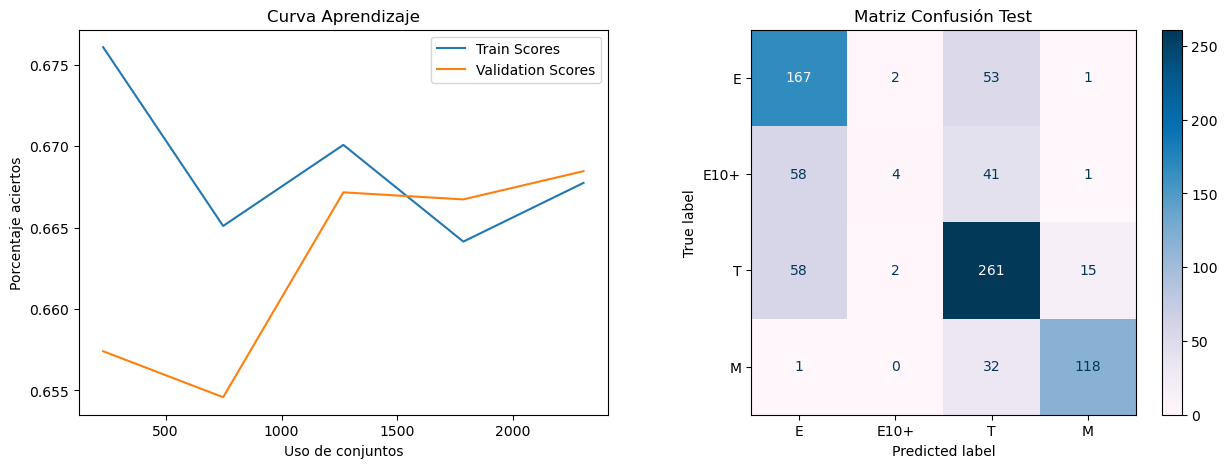

In [11]:
'''
REGRESIÓN LOGISTICA DE N VARIABLES
'''
# Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente a la regresión logística
from sklearn.linear_model import LogisticRegression

# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'penalty': ['l2', 'elasticnet'],
    'C': [1e+101, 1, 1e-101],
    'class_weight': ['balanced', None],
    'solver': ['newton-cg', 'sag', 'saga'],
    'multi_class': ['auto', 'ovr', 'multinomial']
}

# Genera el objeto StratifiedKFold para generar un particionamiento de datos en grupos
ss = StratifiedKFold(n_splits=2,shuffle=True,random_state=0)

#Crea las variables de Regresión Logistica y Grid Search para el aprendizaje
LogReg = LogisticRegression(max_iter=10000, random_state=2)
clasificadores = GridSearchCV(LogReg,parameter_space,cv=ss,n_jobs=-1,scoring='accuracy')

# Entrena el modelo interno de GridSearchCV para obtener los mejores hiperparametros
clasificadores = clasificadores.fit(listOfCaracteristicas_train,listOfRatings_train)
mejorClasificadorESRB['regresionLogistica'][0] = clasificadores.best_estimator_
print(mejorClasificadorESRB['regresionLogistica'][0])

#Mostramos los datos mas interesantes de cada variable predicha
y_true, y_pred = listOfRatings_test , mejorClasificadorESRB['regresionLogistica'][0].predict(listOfCaracteristicas_test)
mejorClasificadorESRB['regresionLogistica'][1] = accuracy_score(y_true, y_pred)
print('\nResults on the test set:')
print(classification_report(y_true, y_pred))
print("ACCURACY OBTENIDO {}".format(mejorClasificadorESRB['regresionLogistica'][1]))

#Obtenemos la curva de aprendizaje y la matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)

curvaError = learning_curve(estimator=mejorClasificadorESRB['regresionLogistica'][0], X=listOfCaracteristicas_train, 
            y=listOfRatings_train, cv=ss, scoring='accuracy')

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title("Curva Aprendizaje")
ax[0].plot(curvaError[0],np.mean(curvaError[1],axis=1),label = r"Train Scores")
ax[0].plot(curvaError[0],np.mean(curvaError[2],axis=1),label = r"Validation Scores")
ax[0].legend(loc = 1)
ax[0].set_xlabel("Uso de conjuntos")
ax[0].set_ylabel("Porcentaje aciertos")
ax[1].set_title("Matriz Confusión Test")
disp.plot(ax=ax[1],cmap='PuBu')

Viendo los datos obtenidos, podemos decir que el acierto no es especialmente alto, fallando sobre todo en la variable _E10+_, con un **0.53%** y acertando en la variable _M_, con un **0.87%**. Por otro lado es interesante fijarse en la variable _recall_, que nos indica que ejemplos de cada clase hemos predicho como la suya propia. Esta es practicamente la misma en casi todas las variables, aproximadamente un **0.75**, menos en la clase _E10+_, la cual consigue un **0.09%**.

¿A qué se puede deber esto? Sabemos que, cuando una clasificación falla, puede ser por multitud de motivos (cantidad de datos, variedad de estos, ruido, características redundantes, etc.). No obstante, en nuestro caso en particular, parece claro que se trata de un problema de distinción entre clases. Como comentábamos al observar la representación gráfica de nuestros ejemplos, las clases _E_ y _E10+_ no cuentan con características que los distingan univocamente. Por el contrario, se podría considerar que una clase engobla a la otra, dificultando notoriamente la predicción. En cualquier caso no vamos a considerar alarmante este fallo, pues, a la hora de realizar una clasificación por edades real, la distinción entre estas dos es considerablemente menos importante que la existente entre las demás.

## Modelo 3: Naive Bayes

En tercer lugar vamos a entrenar un modelo probabilista generativo, Naive Bayes.

GaussianNB()

Results on the test set:
              precision    recall  f1-score   support

           E       0.53      0.90      0.67       223
        E10+       0.00      0.00      0.00       104
           M       0.91      0.60      0.73       151
           T       0.64      0.65      0.64       336

    accuracy                           0.62       814
   macro avg       0.52      0.54      0.51       814
weighted avg       0.58      0.62      0.58       814

ACCURACY OBTENIDO 0.6240786240786241


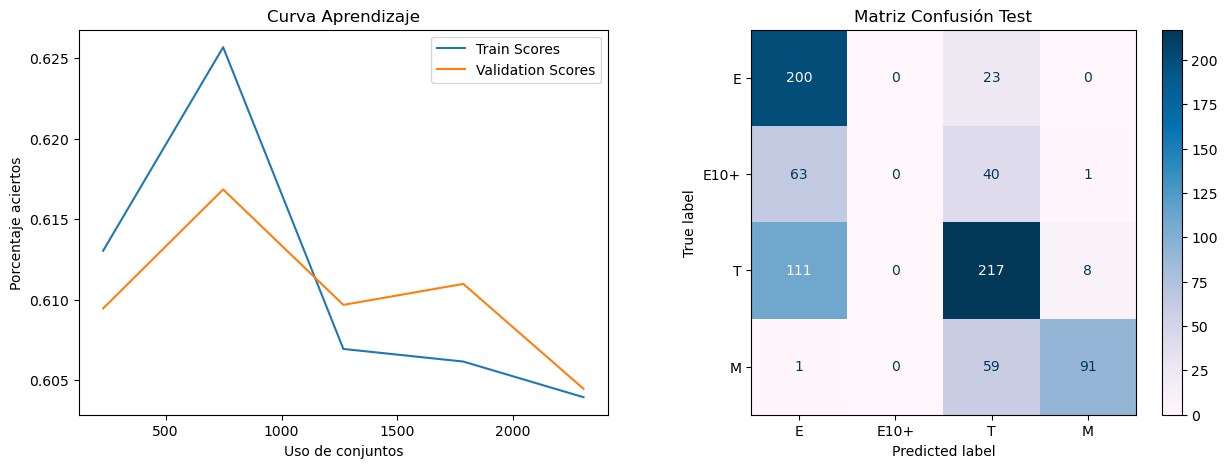

In [12]:
'''
NAIVE BAYES
'''
#Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente a naive bayes
from sklearn.naive_bayes import GaussianNB

# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'priors': [None, len(class_names)]
}

# Genera el objeto StratifiedKFold para generar un particionamiento de datos en grupos
ss = StratifiedKFold(n_splits=2,shuffle=True,random_state=0)

#Crea las variables de Naive Bayes y Grid Search para el aprendizaje
nb = GaussianNB()
clasificadores = GridSearchCV(nb,parameter_space,cv=ss,n_jobs=-1,scoring='accuracy')

# Entrena el modelo interno de GridSearchCV para obtener los mejores hiperparametros
clasificadores = clasificadores.fit(listOfCaracteristicas_train,listOfRatings_train)
mejorClasificadorESRB['nb'][0] = clasificadores.best_estimator_
print(mejorClasificadorESRB['nb'][0])

#Mostramos los datos mas interesantes de cada variable predicha
y_true, y_pred = listOfRatings_test , mejorClasificadorESRB['nb'][0].predict(listOfCaracteristicas_test)
mejorClasificadorESRB['nb'][1] = accuracy_score(y_true, y_pred)
print('\nResults on the test set:')
print(classification_report(y_true, y_pred))
print("ACCURACY OBTENIDO {}".format(mejorClasificadorESRB['nb'][1]))

#Obtenemos la curva de aprendizaje y la matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)

curvaError = learning_curve(estimator=mejorClasificadorESRB['nb'][0], X=listOfCaracteristicas_train, 
            y=listOfRatings_train, cv=ss, scoring='accuracy')

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title("Curva Aprendizaje")
ax[0].plot(curvaError[0],np.mean(curvaError[1],axis=1),label = r"Train Scores")
ax[0].plot(curvaError[0],np.mean(curvaError[2],axis=1),label = r"Validation Scores")
ax[0].legend(loc = 1)
ax[0].set_xlabel("Uso de conjuntos")
ax[0].set_ylabel("Porcentaje aciertos")
ax[1].set_title("Matriz Confusión Test")
disp.plot(ax=ax[1],cmap='PuBu')

Una vez más, obtenemos unos resultados más bien mediocres. La clase _E10+_ demuetra por tercera vez su falta de independencia con respecto a las demás, hasta el punto de no predecir en esa clase ni uno solo de los ejemplos. Por otra parte, los demás resultados obtenidos son ligeramente mejores con respecto a la regresión logística, aunque sin llegar en ningún caso a una conclusión absolutamente satisfactoria.

Cabe destacar que Naive Bayes asume independencia entre las características de los datos. En nuestro caso sin embargo, estas sí que poseen una ligera dependencia entre ellas. Por ejemplo, si bien que un juego sea violento no tiene nada que ver con que contenga desnudos, sí que guarda una estrecha relación con que un juego posea sangre o desmembramientos. Estas pequeñas dependencias pueden haber tenido un impacto negativo en los resultados de este clasificador.

## Modelo 4: Red Neuronal

En cuarto lugar vamos a implementar una red neuronal. Veremos si un clasificador más complejo y con más posibilidades que la regresión logística es también capaz de obtener mejores resultados de precisión.

MLPClassifier(alpha=0.2, hidden_layer_sizes=(50, 50), max_iter=2000,
              random_state=2)

Results on the test set:
              precision    recall  f1-score   support

           E       0.65      0.61      0.63       223
        E10+       0.33      0.26      0.29       104
           M       0.87      0.81      0.84       151
           T       0.67      0.76      0.71       336

    accuracy                           0.66       814
   macro avg       0.63      0.61      0.62       814
weighted avg       0.66      0.66      0.66       814

ACCURACY OBTENIDO 0.6646191646191646


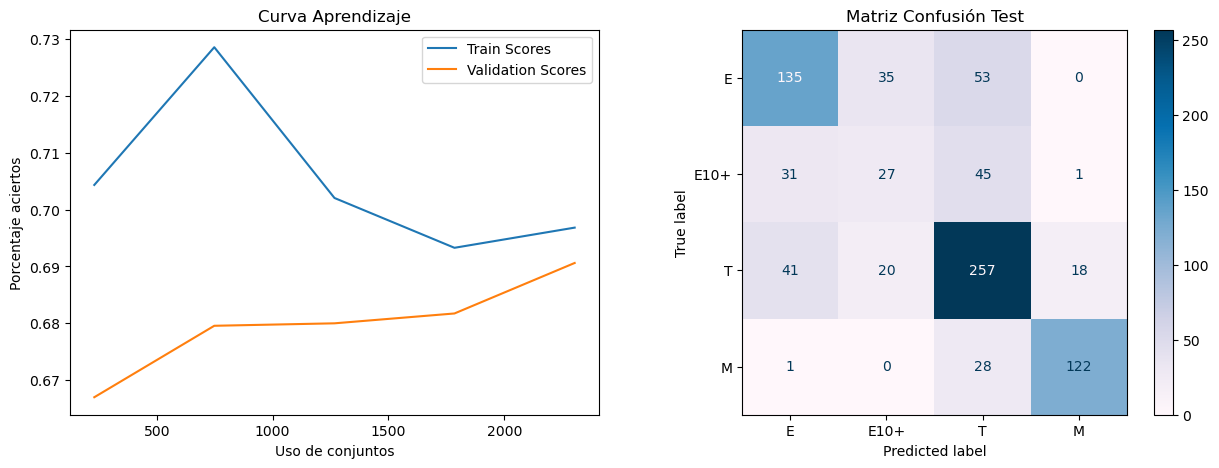

In [13]:
'''
RED NEURONAL
'''
#Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente a la regresión lineal
from sklearn.neural_network import MLPClassifier

# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'hidden_layer_sizes': [(15, 30), (50, 50), (25, 75)],
    'solver': ['sgd', 'adam'],
    'alpha': [0.1, 0.2, 0.35],
    'learning_rate': ['constant','adaptive'],
}

# Genera el objeto StratifiedKFold para generar un particionamiento de datos en grupos
ss = StratifiedKFold(n_splits=2,shuffle=True,random_state=0)

#Crea las variables de MLP Clasificador y Grid Search para el aprendizaje
mlp = MLPClassifier(activation = 'relu', max_iter = 2000, random_state=2)
clasificadores = GridSearchCV(mlp,parameter_space,cv=ss,n_jobs=-1,scoring='accuracy')

# Entrena el modelo interno de GridSearchCV para obtener los mejores hiperparametros
clasificadores = clasificadores.fit(listOfCaracteristicas_train,listOfRatings_train)
mejorClasificadorESRB['redNeuronal'][0] = clasificadores.best_estimator_
print(mejorClasificadorESRB['redNeuronal'][0])

#Mostramos los datos mas interesantes de cada variable predicha
y_true, y_pred = listOfRatings_test , mejorClasificadorESRB['redNeuronal'][0].predict(listOfCaracteristicas_test)
mejorClasificadorESRB['redNeuronal'][1] = accuracy_score(y_true, y_pred)
print('\nResults on the test set:')
print(classification_report(y_true, y_pred))
print("ACCURACY OBTENIDO {}".format(mejorClasificadorESRB['redNeuronal'][1]))

#Obtenemos la curva de aprendizaje y la matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)

curvaError = learning_curve(estimator=mejorClasificadorESRB['redNeuronal'][0], X=listOfCaracteristicas_train, 
            y=listOfRatings_train, cv=ss, scoring='accuracy')

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title("Curva Aprendizaje")
ax[0].plot(curvaError[0],np.mean(curvaError[1],axis=1),label = r"Train Scores")
ax[0].plot(curvaError[0],np.mean(curvaError[2],axis=1),label = r"Validation Scores")
ax[0].legend(loc = 1)
ax[0].set_xlabel("Uso de conjuntos")
ax[0].set_ylabel("Porcentaje aciertos")
ax[1].set_title("Matriz Confusión Test")
disp.plot(ax=ax[1],cmap='PuBu')

En general, vemos que la red neuronal es capaz de alcanzar resultados notablemente mejores a los obtenidos anteriormente, pudiendo superar el **0.7%** de precisión total en algunos casos. Seguimos viendo que la clase _M_ está bastante bien predicha, con un **0.86%**. Ha habido un aumento considerable en las demás clases, pero seguimos teniendo en la variable _E10+_ alrededor de un **0.5%** de acierto, manteniendo nuestra tesis de tratarse de una clase conflictiva.

¿Y a qué se debe la mejoría en las otras clases? Debemos recalcar, en primer lugar, que esta no es particularmente notoría, aunque a lo largo de diversas iteraciones sí demuestra ser consistente. Sabemos que las redes neuronales son, de forma simplista, una unión de regresiones logísticas. Como hemos observado en nuestros datos inicialmente, estos no son fácilmente separables linealmente en lo absoluto, con lo que una única regresión lógistica no es un modelo óptimo. Por otra parte, la red neuronal propone un sistema mucho más flexibe y capaz de adaptarse a distribuciones de datos tan particulares como los nuestros, recogiendo así como parte de una misma clase a ejemplos que quizá se consideraban "ouliers" en la distribución original.

## Modelo 5: SVMs

Seguimos con otro modelo distinto. En este caso, los SVMs o _support vector machines_. La idea detrás de estos es buscar la frontera de decisión de margen máximo con los ejemplos que tenemos. No son linealmente separables, con lo que tendremos que utilizar alguna función kernel (funciones que permiten la clasificación no lineal). De nuevo, tanto el kernel como los diversos hiperparámetros del modelo son seleccionados automáticamente.

SVC(C=2, decision_function_shape='ovo', gamma=3, probability=True,
    random_state=2) rbf

Results on the test set:
              precision    recall  f1-score   support

           E       0.70      0.74      0.72       223
        E10+       0.55      0.23      0.32       104
           M       0.87      0.77      0.82       151
           T       0.67      0.80      0.73       336

    accuracy                           0.71       814
   macro avg       0.70      0.64      0.65       814
weighted avg       0.70      0.71      0.69       814

ACCURACY OBTENIDO 0.7063882063882064


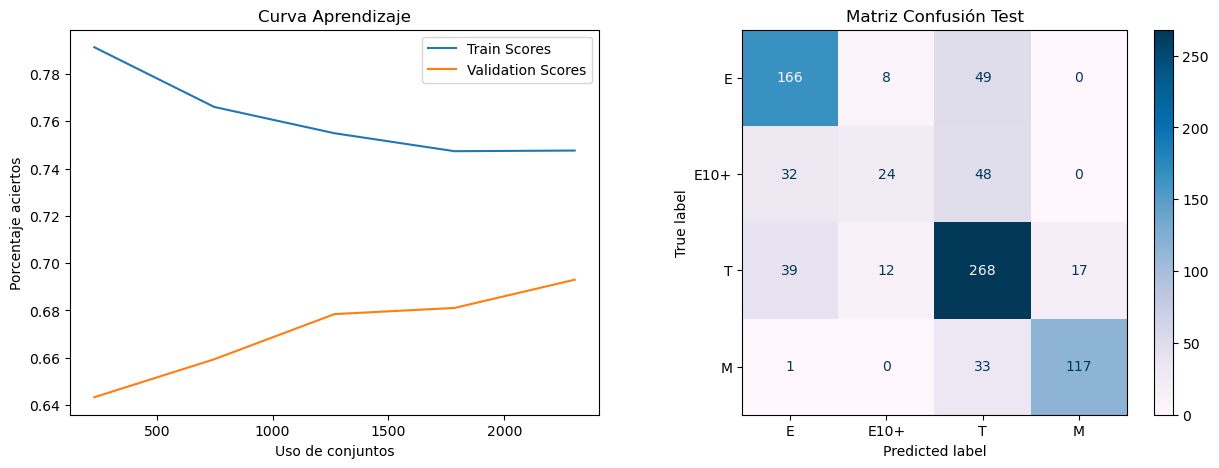

In [14]:
'''
SVM
'''
#Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente a la svm
from sklearn import svm

# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'C': [0.5, 2, 1], 
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': [3, 5, 10],
    'decision_function_shape': ['ovo', 'ovr']
}

# Genera el objeto StratifiedKFold para generar un particionamiento de datos en grupos
ss = StratifiedKFold(n_splits=2,shuffle=True,random_state=0)

#Crea las variables de SVM y Grid Search para el aprendizaje
svc = svm.SVC(max_iter=-1, random_state=2, probability=True)
clasificadores = GridSearchCV(svc,parameter_space,cv=ss,n_jobs=-1,scoring='accuracy')

# Entrena el modelo interno de GridSearchCV para obtener los mejores hiperparametros
clasificadores = clasificadores.fit(listOfCaracteristicas_train,listOfRatings_train)
mejorClasificadorESRB['svm'][0] = clasificadores.best_estimator_
print(mejorClasificadorESRB['svm'][0], mejorClasificadorESRB['svm'][0].kernel)

#Mostramos los datos mas interesantes de cada variable predicha
y_true, y_pred = listOfRatings_test , mejorClasificadorESRB['svm'][0].predict(listOfCaracteristicas_test)
mejorClasificadorESRB['svm'][1] = accuracy_score(y_true, y_pred)
print('\nResults on the test set:')
print(classification_report(y_true, y_pred))
print("ACCURACY OBTENIDO {}".format(mejorClasificadorESRB['svm'][1]))

#Obtenemos la curva de aprendizaje y la matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)

curvaError = learning_curve(estimator=mejorClasificadorESRB['svm'][0], X=listOfCaracteristicas_train, 
            y=listOfRatings_train, cv=ss, scoring='accuracy')

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title("Curva Aprendizaje")
ax[0].plot(curvaError[0],np.mean(curvaError[1],axis=1),label = r"Train Scores")
ax[0].plot(curvaError[0],np.mean(curvaError[2],axis=1),label = r"Validation Scores")
ax[0].legend(loc = 1)
ax[0].set_xlabel("Uso de conjuntos")
ax[0].set_ylabel("Porcentaje aciertos")
ax[1].set_title("Matriz Confusión Test")
disp.plot(ax=ax[1],cmap='PuBu')

Los resultados obtenidos por el SVM son similares a los observados mediante la Red Neuronal. No obstante, es notable el buen rendimiento de las clases  _T_ y _M_. Estos resultados, sin ser mucho mejores que los ya vistos, sí que nos dan una idea aproxiamada de la distribución de nuestros ejemplos, que, como se podría suponer, no son separables linealmente (obsérvese que GridSearchCV escoge un Kernel **rbf**, este mismo intenta ajustar los margenes lo máximo posible entre sus datos), mientras que, para variar, la clase _E10+_ no es distinguible en lo absoluto de sus clases "vecinas".

## Modelo 6: Ensembles

Hasta ahora, nuestros modelos se han basado en un único clasificador, ¿qué ocurre si en su lugar usamos varios? Esto es a lo que pretenden responder los ensembles. En esta parte, entrenaremos varios modelos distintos de ensemble para tratar de predecir lo mejor posible.

### Ensembles basados en variación de datos

#### Ensemble 1: Decision Tree

En este caso, sigue siendo un solo predictor único, pero lo realizamos ya que este mismo arbol se seguirá usando como base para los siguientes ensembles. Por otro lado, no descartar la idea que pueda ser también un clasificador bueno por sí solo.

DecisionTreeClassifier(min_samples_split=10, random_state=2)

Results on the test set:
              precision    recall  f1-score   support

           E       0.67      0.74      0.71       223
        E10+       0.52      0.31      0.39       104
           M       0.86      0.82      0.84       151
           T       0.68      0.74      0.71       336

    accuracy                           0.70       814
   macro avg       0.68      0.65      0.66       814
weighted avg       0.69      0.70      0.69       814

ACCURACY OBTENIDO 0.699017199017199


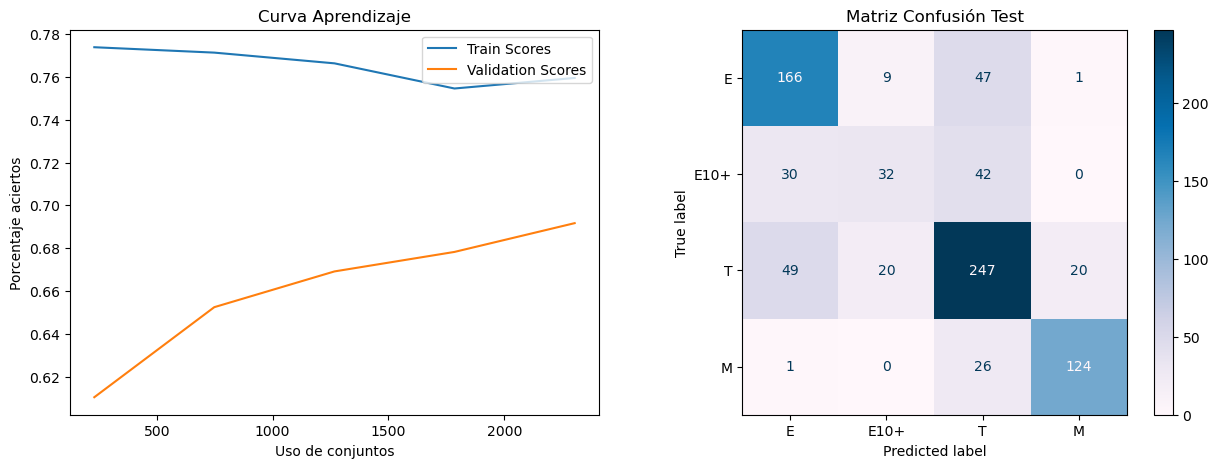

In [15]:
'''
DECISION TREE
'''
#Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente al decision tree
from sklearn.tree import DecisionTreeClassifier

# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'class_weight': ['balanced', None]
}

# Genera el objeto StratifiedKFold para generar un particionamiento de datos en grupos
ss = StratifiedKFold(n_splits=2,shuffle=True,random_state=0)

#Crea las variables de Decision Tree y Grid Search para el aprendizaje
arbol = DecisionTreeClassifier(random_state=2)
clasificadores = GridSearchCV(arbol,parameter_space,cv=ss,n_jobs=-1,scoring='accuracy')

# Entrena el modelo interno de GridSearchCV para obtener los mejores hiperparametros
clasificadores = clasificadores.fit(listOfCaracteristicas_train,listOfRatings_train)
mejorClasificadorESRB['decisionTree'][0] = clasificadores.best_estimator_
print(mejorClasificadorESRB['decisionTree'][0])

#Mostramos los datos mas interesantes de cada variable predicha
y_true, y_pred = listOfRatings_test , mejorClasificadorESRB['decisionTree'][0].predict(listOfCaracteristicas_test)
mejorClasificadorESRB['decisionTree'][1] = accuracy_score(y_true, y_pred)
print('\nResults on the test set:')
print(classification_report(y_true, y_pred))
print("ACCURACY OBTENIDO {}".format(mejorClasificadorESRB['decisionTree'][1]))

#Obtenemos la curva de aprendizaje y la matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)

curvaError = learning_curve(estimator=mejorClasificadorESRB['decisionTree'][0], X=listOfCaracteristicas_train, 
            y=listOfRatings_train, cv=ss, scoring='accuracy')

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title("Curva Aprendizaje")
ax[0].plot(curvaError[0],np.mean(curvaError[1],axis=1),label = r"Train Scores")
ax[0].plot(curvaError[0],np.mean(curvaError[2],axis=1),label = r"Validation Scores")
ax[0].legend(loc = 1)
ax[0].set_xlabel("Uso de conjuntos")
ax[0].set_ylabel("Porcentaje aciertos")
ax[1].set_title("Matriz Confusión Test")
disp.plot(ax=ax[1],cmap='PuBu')

De forma notable, decision tree arroja resultados más que decentes pese a su simplicidad.

Este no es el mejor clasificador por sí solo, pero al ser usado como base, veremos si se acaban obteniendo buenos resultados o no.

#### Ensemble 2: Random Forest

Random forest se fundamenta en crear un conjunto de árboles que vayan variando la cantidad de atributos en los distintos niveles de los mismos. Recordemos, eso sí, que hemos aplicado previamente PCA a nuestros datos reduciendo considerablemente el número de atributos. Esto puede afectar negativamente al rendimiento de random forest.

RandomForestClassifier(max_features='sqrt', min_samples_split=10,
                       n_estimators=20, random_state=2)

Results on the test set:
              precision    recall  f1-score   support

           E       0.69      0.74      0.71       223
        E10+       0.52      0.22      0.31       104
           M       0.87      0.81      0.84       151
           T       0.68      0.78      0.72       336

    accuracy                           0.70       814
   macro avg       0.69      0.64      0.65       814
weighted avg       0.69      0.70      0.69       814

ACCURACY OBTENIDO 0.7039312039312039


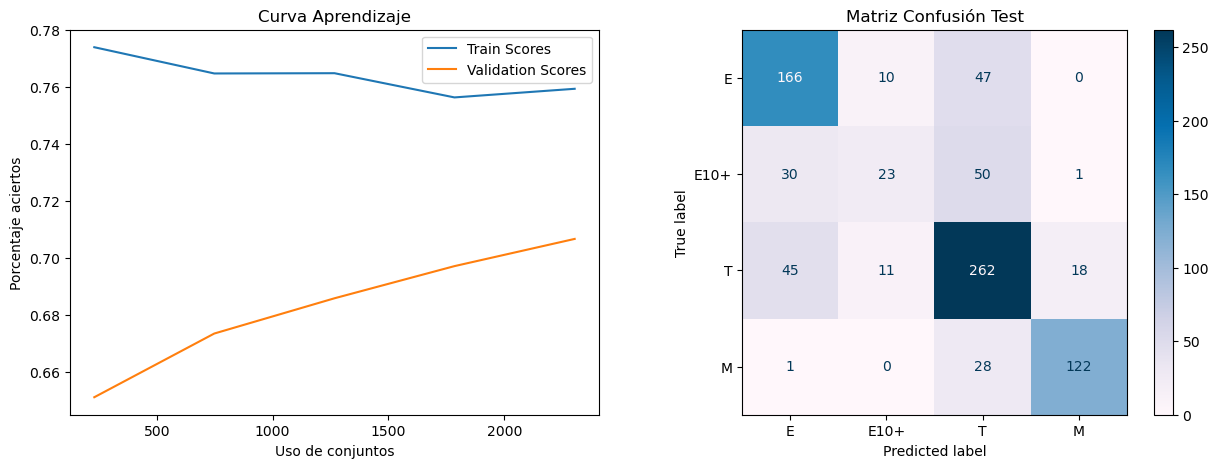

In [16]:
'''
RANDOM FOREST
'''
#Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente al random forest
from sklearn.ensemble import RandomForestClassifier

# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'n_estimators': [50, 100, 5, 20, 75],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'bootstrap': [True, False]
    # 'max_samples': [100, 500, 1000, 2000]
}

# Genera el objeto StratifiedKFold para generar un particionamiento de datos en grupos
ss = StratifiedKFold(n_splits=2,shuffle=True,random_state=0)

#Crea las variables de Random Forest y Grid Search para el aprendizaje
arbol = RandomForestClassifier(random_state=2)
clasificadores = GridSearchCV(arbol,parameter_space,cv=ss,n_jobs=-1,scoring='accuracy')

# Entrena el modelo interno de GridSearchCV para obtener los mejores hiperparametros
clasificadores = clasificadores.fit(listOfCaracteristicas_train,listOfRatings_train)
mejorClasificadorESRB['randomForest'][0] = clasificadores.best_estimator_
print(mejorClasificadorESRB['randomForest'][0])

#Mostramos los datos mas interesantes de cada variable predicha
y_true, y_pred = listOfRatings_test , mejorClasificadorESRB['randomForest'][0].predict(listOfCaracteristicas_test)
mejorClasificadorESRB['randomForest'][1] = accuracy_score(y_true, y_pred)
print('\nResults on the test set:')
print(classification_report(y_true, y_pred))
print("ACCURACY OBTENIDO {}".format(mejorClasificadorESRB['randomForest'][1]))

#Obtenemos la curva de aprendizaje y la matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)

curvaError = learning_curve(estimator=mejorClasificadorESRB['randomForest'][0], X=listOfCaracteristicas_train, 
            y=listOfRatings_train, cv=ss, scoring='accuracy')

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title("Curva Aprendizaje")
ax[0].plot(curvaError[0],np.mean(curvaError[1],axis=1),label = r"Train Scores")
ax[0].plot(curvaError[0],np.mean(curvaError[2],axis=1),label = r"Validation Scores")
ax[0].legend(loc = 1)
ax[0].set_xlabel("Uso de conjuntos")
ax[0].set_ylabel("Porcentaje aciertos")
ax[1].set_title("Matriz Confusión Test")
disp.plot(ax=ax[1],cmap='PuBu')

Los resultados obtenidos en general por este algoritmo son, sorpresivamente, semejantes a los obtenidos anteriormente, resulta especialmente notable la buena predicción obtenida sobre la clase _M_. Esto refuerza la idea que teníamos sobre la distinción de extremos, pues aún usando menos atributos y perdiendo información relevante por el camino, los ejemplos de esta clase poseen características tan única que, pese a todo, siguien siendo predichos correctamente en su mayoría.

#### Ensemble 3: Adaboost con decision stumps

En tercer lugar, usaremos un adaboost (o boosting) para encontrar el mejor modelo. Este adaboost lo construiremos con árboles de un solo nodo (decision stumps) como clasificador base. Sin embargo, a la hora de realizar el boosting es importante tener en cuenta el número de clasificadores que queremos utilizar. Como siempre, el problema se reduce a que usando pocos no nos ajustamos y si usamos demasiado estaremos sobreentrenando.

AdaBoostClassifier(base_estimator=RandomForestClassifier(max_features='sqrt',
                                                         min_samples_split=10,
                                                         n_estimators=20,
                                                         random_state=2),
                   learning_rate=1, n_estimators=5, random_state=2)

Results on the test set:
              precision    recall  f1-score   support

           E       0.70      0.66      0.68       223
        E10+       0.52      0.23      0.32       104
           M       0.87      0.81      0.84       151
           T       0.65      0.81      0.72       336

    accuracy                           0.70       814
   macro avg       0.69      0.63      0.64       814
weighted avg       0.69      0.70      0.68       814

ACCURACY OBTENIDO 0.6953316953316954


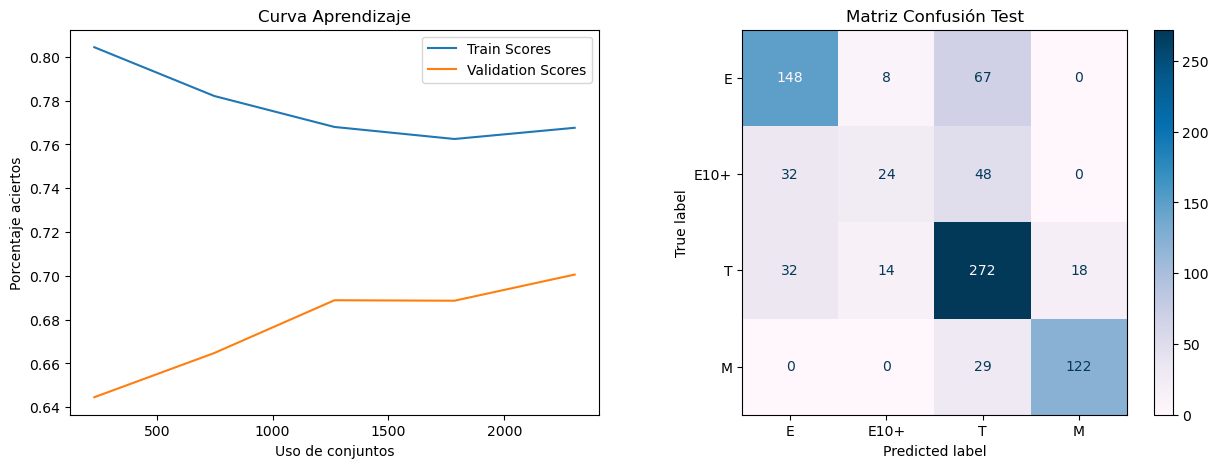

In [17]:
'''
ADABOOST CON DECISION STUMPS
'''
#Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente al adaboost
from sklearn.ensemble import AdaBoostClassifier

# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'base_estimator': [mejorClasificadorESRB['decisionTree'][0], mejorClasificadorESRB['svm'][0], mejorClasificadorESRB['randomForest'][0],
                        mejorClasificadorESRB['regresionLogistica'][0], mejorClasificadorESRB['nb'][0]],
    'n_estimators': [5, 50, 100],
    'learning_rate': [1, 5, 0.5,],
}

# Genera el objeto StratifiedKFold para generar un particionamiento de datos en grupos
ss = StratifiedKFold(n_splits=2,shuffle=True,random_state=0)

#Crea las variables de Adaboost y Grid Search para el aprendizaje
adaboost = AdaBoostClassifier(random_state=2,algorithm='SAMME.R')
clasificadores = GridSearchCV(adaboost,parameter_space,cv=ss,n_jobs=-1,scoring='accuracy')

# Entrena el modelo interno de GridSearchCV para obtener los mejores hiperparametros
clasificadores = clasificadores.fit(listOfCaracteristicas_train,listOfRatings_train)
mejorClasificadorESRB['adaboost'][0] = clasificadores.best_estimator_
print(mejorClasificadorESRB['adaboost'][0])

#Mostramos los datos mas interesantes de cada variable predicha
y_true, y_pred = listOfRatings_test , mejorClasificadorESRB['adaboost'][0].predict(listOfCaracteristicas_test)
mejorClasificadorESRB['adaboost'][1] = accuracy_score(y_true, y_pred)
print('\nResults on the test set:')
print(classification_report(y_true, y_pred))
print("ACCURACY OBTENIDO {}".format(mejorClasificadorESRB['adaboost'][1]))

#Obtenemos la curva de aprendizaje y la matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)

curvaError = learning_curve(estimator=mejorClasificadorESRB['adaboost'][0], X=listOfCaracteristicas_train, 
            y=listOfRatings_train, cv=ss, scoring='accuracy')

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title("Curva Aprendizaje")
ax[0].plot(curvaError[0],np.mean(curvaError[1],axis=1),label = r"Train Scores")
ax[0].plot(curvaError[0],np.mean(curvaError[2],axis=1),label = r"Validation Scores")
ax[0].legend(loc = 1)
ax[0].set_xlabel("Uso de conjuntos")
ax[0].set_ylabel("Porcentaje aciertos")
ax[1].set_title("Matriz Confusión Test")
disp.plot(ax=ax[1],cmap='PuBu')

Habiendo ejecutado el código anterior, obtenemos una precisión aproximada del **68%**. Hemos obtenido casi un calco de los mismos aciertos y fallos anteriores. Sigue siendo sorprendente la dificultad que tienen los modelos para encontrar un resultado óptimo a nuestro problema.

#### Ensemble 4: Bagging con decision stumps

Ahora emplearemos bagging para hacer la predicción. El modelo base vuelve a ser un decision stump. De nuevo, el resultado varía mucho en función de cual sea el número de clasificadores, así que volveremos a iterar sobre unos cuantos para encontrar el óptimo.

BaggingClassifier(base_estimator=RandomForestClassifier(max_features='sqrt',
                                                        min_samples_split=10,
                                                        n_estimators=20,
                                                        random_state=2),
                  n_estimators=30, random_state=2)

Results on the test set:
              precision    recall  f1-score   support

           E       0.70      0.74      0.72       223
        E10+       0.45      0.18      0.26       104
           M       0.87      0.79      0.83       151
           T       0.67      0.79      0.72       336

    accuracy                           0.70       814
   macro avg       0.67      0.63      0.63       814
weighted avg       0.69      0.70      0.68       814

ACCURACY OBTENIDO 0.699017199017199


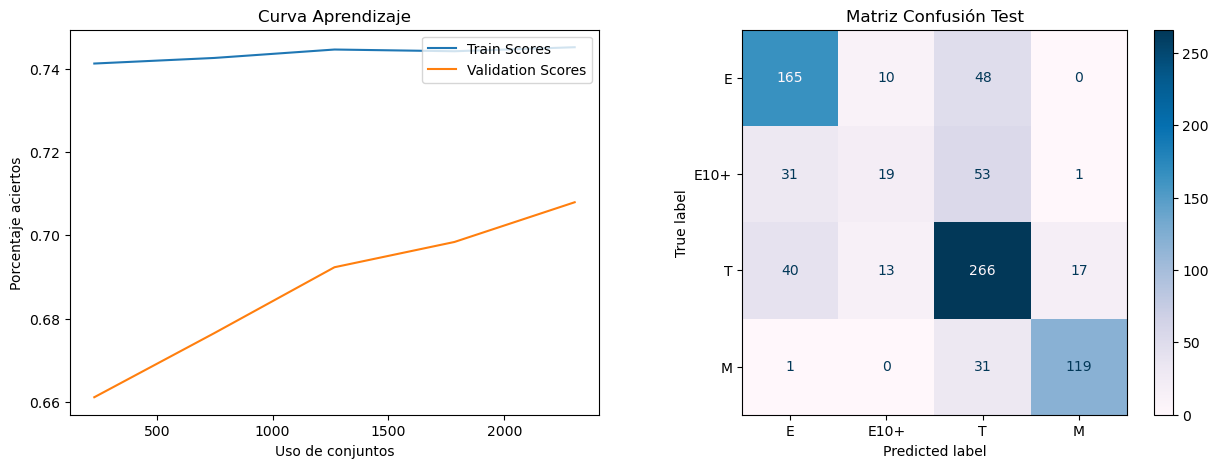

In [18]:
'''
BAGGING CON DECISION STUMPS
'''
#Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente al bagging
from sklearn.ensemble import BaggingClassifier

# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'base_estimator': [mejorClasificadorESRB['decisionTree'][0], mejorClasificadorESRB['svm'][0], mejorClasificadorESRB['randomForest'][0],
                        mejorClasificadorESRB['regresionLogistica'][0], mejorClasificadorESRB['nb'][0], mejorClasificadorESRB['redNeuronal'][0]],
    'n_estimators': [1, 10, 30],
    'bootstrap_features': [False, True]
}

# Genera el objeto StratifiedKFold para generar un particionamiento de datos en grupos
ss = StratifiedKFold(n_splits=2,shuffle=True,random_state=0)

#Crea las variables de Boosting y Grid Search para el aprendizaje
bagging = BaggingClassifier(random_state=2)
clasificadores = GridSearchCV(bagging,parameter_space,cv=ss,n_jobs=-1,scoring='accuracy')

# Entrena el modelo interno de GridSearchCV para obtener los mejores hiperparametros
clasificadores = clasificadores.fit(listOfCaracteristicas_train,listOfRatings_train)
mejorClasificadorESRB['bagging'][0] = clasificadores.best_estimator_
print(mejorClasificadorESRB['bagging'][0])

#Mostramos los datos mas interesantes de cada variable predicha
y_true, y_pred = listOfRatings_test , mejorClasificadorESRB['bagging'][0].predict(listOfCaracteristicas_test)
mejorClasificadorESRB['bagging'][1] = accuracy_score(y_true, y_pred)
print('\nResults on the test set:')
print(classification_report(y_true, y_pred))
print("ACCURACY OBTENIDO {}".format(mejorClasificadorESRB['bagging'][1]))

#Obtenemos la curva de aprendizaje y la matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)

curvaError = learning_curve(estimator=mejorClasificadorESRB['bagging'][0], X=listOfCaracteristicas_train, 
            y=listOfRatings_train, cv=ss, scoring='accuracy')

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title("Curva Aprendizaje")
ax[0].plot(curvaError[0],np.mean(curvaError[1],axis=1),label = r"Train Scores")
ax[0].plot(curvaError[0],np.mean(curvaError[2],axis=1),label = r"Validation Scores")
ax[0].legend(loc = 1)
ax[0].set_xlabel("Uso de conjuntos")
ax[0].set_ylabel("Porcentaje aciertos")
ax[1].set_title("Matriz Confusión Test")
disp.plot(ax=ax[1],cmap='PuBu')

Bagging nos devuelve valores parecidos a Adaboost. La diferencia está en la bajada de los valores _recall_ que empeoran ligeramente. 

### Ensembles basados en descomposición

#### Ensemble 1: One vs All

Este ensemble nos divide el problema multi-clase en tantos problemas como clases tengamos. Averiguaremos si mejora o no los resultados anteriores.

OneVsRestClassifier(estimator=SVC(C=2, decision_function_shape='ovo', gamma=3,
                                  probability=True, random_state=2))

Results on the test set:
              precision    recall  f1-score   support

           E       0.67      0.62      0.65       223
        E10+       0.33      0.27      0.30       104
           M       0.88      0.79      0.83       151
           T       0.69      0.79      0.73       336

    accuracy                           0.68       814
   macro avg       0.64      0.62      0.63       814
weighted avg       0.67      0.68      0.67       814

ACCURACY OBTENIDO 0.6781326781326781


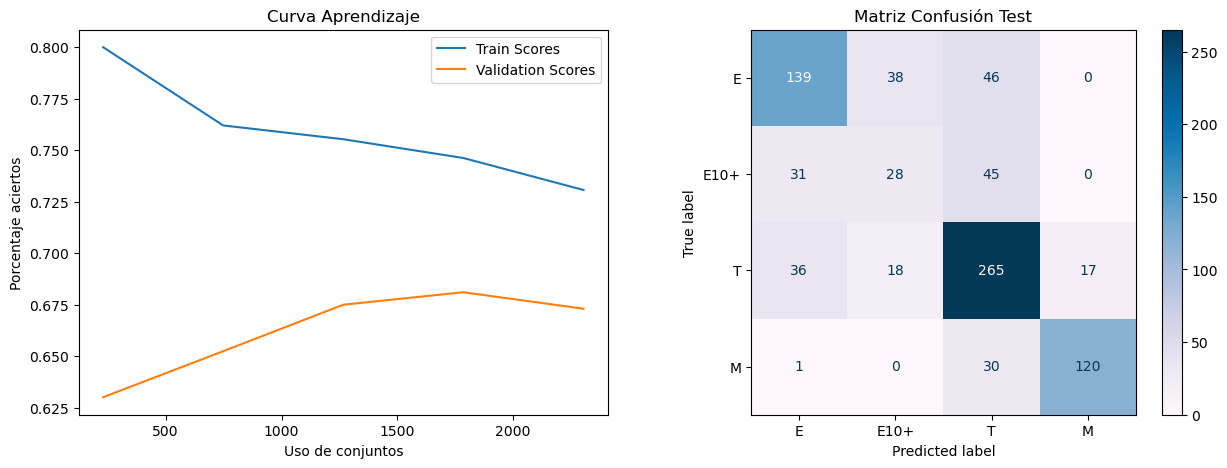

In [19]:
'''
ONE VS ALL
'''
#Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente al ova
from sklearn.multiclass import OneVsRestClassifier

# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'estimator': [svm.SVR(), mejorClasificadorESRB['svm'][0]]
}

# Genera el objeto StratifiedKFold para generar un particionamiento de datos en grupos
ss = StratifiedKFold(n_splits=2,shuffle=True,random_state=0)

#Crea las variables de OVA y Grid Search para el aprendizaje
ova = OneVsRestClassifier(estimator=mejorClasificadorESRB['svm'][0])
clasificadores = GridSearchCV(ova,parameter_space,cv=ss,n_jobs=-1,scoring='accuracy')

# Entrena el modelo interno de GridSearchCV para obtener los mejores hiperparametros
clasificadores = clasificadores.fit(listOfCaracteristicas_train,listOfRatings_train)
mejorClasificadorESRB['ova'][0] = clasificadores.best_estimator_
print(mejorClasificadorESRB['ova'][0])

#Mostramos los datos mas interesantes de cada variable predicha
y_true, y_pred = listOfRatings_test , mejorClasificadorESRB['ova'][0].predict(listOfCaracteristicas_test)
mejorClasificadorESRB['ova'][1] = accuracy_score(y_true, y_pred)
print('\nResults on the test set:')
print(classification_report(y_true, y_pred))
print("ACCURACY OBTENIDO {}".format(mejorClasificadorESRB['ova'][1]))

#Obtenemos la curva de aprendizaje y la matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)

curvaError = learning_curve(estimator=mejorClasificadorESRB['ova'][0], X=listOfCaracteristicas_train, 
            y=listOfRatings_train, cv=ss, scoring='accuracy')

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title("Curva Aprendizaje")
ax[0].plot(curvaError[0],np.mean(curvaError[1],axis=1),label = r"Train Scores")
ax[0].plot(curvaError[0],np.mean(curvaError[2],axis=1),label = r"Validation Scores")
ax[0].legend(loc = 1)
ax[0].set_xlabel("Uso de conjuntos")
ax[0].set_ylabel("Porcentaje aciertos")
ax[1].set_title("Matriz Confusión Test")
disp.plot(ax=ax[1],cmap='PuBu')

Usando un modelo de One vs All, obtenemos valores un poco inferiores a los ensembles anteriores. Destacar el mal resultado sobre la clase _E10+_ (para variar). One Vs All genera una zona de clasificación alrededor de los ejemplos de cada una de las clases. Cabría esperar que, bajo estas circunstancias, la zona propia de la clase _E10+_ fuera lo bastante distintiva como para predecir parte de sus ejemplos correctamente. No obtante, como ya hemos observado anteriormente, los ejemplos de esta clase se parecen demasiado a los de sus clases vecinas, haciendo que OVA se decante por estos en su lugar.

#### Ensemble 2: One vs One

Por último, vamos a implementar el modelo de One vs One con un support vector machine como clasificador base.

OneVsOneClassifier(estimator=SVC(C=2, decision_function_shape='ovo', gamma=3,
                                 probability=True, random_state=2))

Results on the test set:
              precision    recall  f1-score   support

           E       0.70      0.74      0.72       223
        E10+       0.55      0.23      0.32       104
           M       0.87      0.77      0.82       151
           T       0.67      0.80      0.73       336

    accuracy                           0.71       814
   macro avg       0.70      0.64      0.65       814
weighted avg       0.70      0.71      0.69       814

ACCURACY OBTENIDO 0.7063882063882064


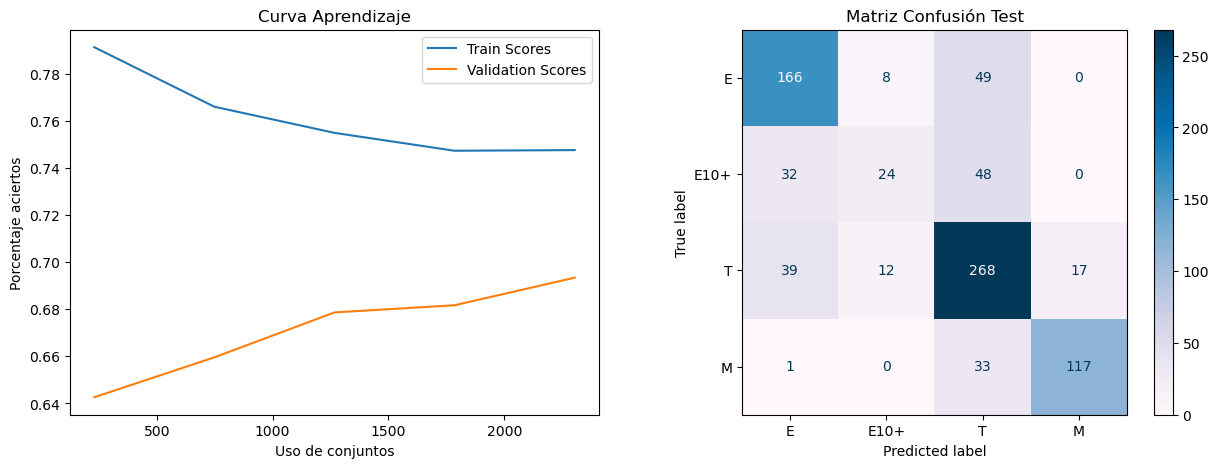

In [20]:
'''
ONE VS ONE
'''
#Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente al ovo
from sklearn.multiclass import OneVsOneClassifier

# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'estimator': [svm.SVR(), mejorClasificadorESRB['svm'][0]]
}

# Genera el objeto StratifiedKFold para generar un particionamiento de datos en grupos
ss = StratifiedKFold(n_splits=2,shuffle=True,random_state=0)

#Crea las variables de OVO y Grid Search para el aprendizaje
ovo = OneVsOneClassifier(estimator=mejorClasificadorESRB['svm'][0])
clasificadores = GridSearchCV(ovo,parameter_space,cv=ss,n_jobs=-1,scoring='accuracy')

# Entrena el modelo interno de GridSearchCV para obtener los mejores hiperparametros
clasificadores = clasificadores.fit(listOfCaracteristicas_train,listOfRatings_train)
mejorClasificadorESRB['ovo'][0] = clasificadores.best_estimator_
print(mejorClasificadorESRB['ovo'][0])

#Mostramos los datos mas interesantes de cada variable predicha
y_true, y_pred = listOfRatings_test , mejorClasificadorESRB['ovo'][0].predict(listOfCaracteristicas_test)
mejorClasificadorESRB['ovo'][1] = accuracy_score(y_true, y_pred)
print('\nResults on the test set:')
print(classification_report(y_true, y_pred))
print("ACCURACY OBTENIDO {}".format(mejorClasificadorESRB['ovo'][1]))

#Obtenemos la curva de aprendizaje y la matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)

curvaError = learning_curve(estimator=mejorClasificadorESRB['ovo'][0], X=listOfCaracteristicas_train, 
            y=listOfRatings_train, cv=ss, scoring='accuracy')

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title("Curva Aprendizaje")
ax[0].plot(curvaError[0],np.mean(curvaError[1],axis=1),label = r"Train Scores")
ax[0].plot(curvaError[0],np.mean(curvaError[2],axis=1),label = r"Validation Scores")
ax[0].legend(loc = 1)
ax[0].set_xlabel("Uso de conjuntos")
ax[0].set_ylabel("Porcentaje aciertos")
ax[1].set_title("Matriz Confusión Test")
disp.plot(ax=ax[1],cmap='PuBu')

Obtenemos, de nuevo, una ligera mejora con respecto al modelo anterior, pero siguen sin ser los mejores.

## Modelo 7: KMeans

El último modelo que vamos a implementar es Kmeans. Nuevamente, se trata de un modelo ideal para nuestro problema, pues sabemos que estos deben ser separables en clases y además conocemos previamente el número de clústeres que necesitamos (4), con lo que nos ahorramos mucho trabajo de optimización.

KMeans(algorithm='elkan', n_clusters=4, random_state=2)

Results on the test set:
              precision    recall  f1-score   support

         0.0       0.28      1.00      0.43       223
         1.0       0.00      0.00      0.00       104
         2.0       1.00      0.01      0.01       151
         3.0       1.00      0.01      0.02       336

    accuracy                           0.28       814
   macro avg       0.57      0.25      0.12       814
weighted avg       0.67      0.28      0.13       814

ACCURACY OBTENIDO 0.2788697788697789


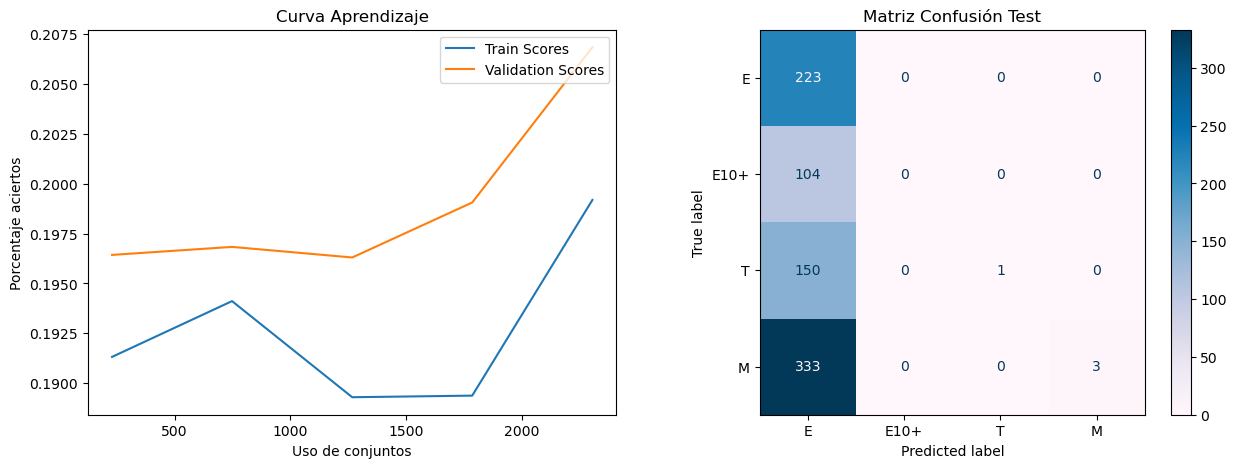

In [21]:
'''
K-MEANS
'''
#Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente al k-means
from sklearn.cluster import KMeans

# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'algorithm': ['lloyd', 'elkan']
}

# Genera el objeto StratifiedKFold para generar un particionamiento de datos en grupos
ss = StratifiedKFold(n_splits=2,shuffle=True,random_state=0)

#Crea las variables de KMeans y Grid Search para el aprendizaje
km = KMeans(n_clusters=len(class_names), random_state=2)
clasificadores = GridSearchCV(km,parameter_space,cv=ss,n_jobs=-1,scoring='accuracy')

# Entrena el modelo interno de GridSearchCV para obtener los mejores hiperparametros
clasificadores = clasificadores.fit(listOfCaracteristicas_train,listOfRatings_trainLE.astype(np.float64))
mejorClasificadorESRB['kmeans'][0] = clasificadores.best_estimator_
print(mejorClasificadorESRB['kmeans'][0])

# Mostramos los datos mas interesantes de cada variable predicha
df = pd.DataFrame({'clusters' : mejorClasificadorESRB['kmeans'][0].labels_, 'ratings' : listOfRatings_trainLE.flatten()})
y_pred = np.zeros_like(listOfRatings_testLE)
pred = mejorClasificadorESRB['kmeans'][0].predict(listOfCaracteristicas_test)
for i in pred:
    y_pred[i] = np.argmax(np.bincount(df[df.clusters==i].ratings))
y_true, y_pred = listOfRatings_testLE.astype(np.float32), y_pred
mejorClasificadorESRB['kmeans'][1] = accuracy_score(y_true, y_pred)
print('\nResults on the test set:')
print(classification_report(y_true, y_pred))
print("ACCURACY OBTENIDO {}".format(mejorClasificadorESRB['kmeans'][1]))

#Obtenemos la curva de aprendizaje y la matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)

curvaError = learning_curve(estimator=mejorClasificadorESRB['kmeans'][0], X=listOfCaracteristicas_train, 
            y=listOfRatings_trainLE.astype(np.float32), cv=ss, scoring='adjusted_mutual_info_score')

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title("Curva Aprendizaje")
ax[0].plot(curvaError[0],np.mean(curvaError[1],axis=1),label = r"Train Scores")
ax[0].plot(curvaError[0],np.mean(curvaError[2],axis=1),label = r"Validation Scores")
ax[0].legend(loc = 1)
ax[0].set_xlabel("Uso de conjuntos")
ax[0].set_ylabel("Porcentaje aciertos")
ax[1].set_title("Matriz Confusión Test")
disp.plot(ax=ax[1],cmap='PuBu')

Aunque habíamos dicho que nuestro problema podría ser resuelto por Kmeans, este demuestra no ser en lo absoluto útil. Estos malísimos resultados pueden deberse a varios motivos, como por ejemplo que nuestro problema es de aprendizaje supervisado mientras que Kmeans es un modelo para el NO supervisado. Sin embargo, el motivo del fallo salta a la vista, el número desorbitado de datos de la clase _E_ frente a las otras 3. Si bien esto es problema nuestro (los datos no están equilibrados en su representación por clases), la propia tendencia de las clasificaciones del mundo real es la que devuelve estos datos, que por otra parte no tendría sentido "trucar" forzando a una misma cantidad de ejemplos de todas las clases. Basicamente, Kmeans nos permite reflexionar sobre lo siguiente: hay muchos más juegos con características propias de títulos para todas las edades que de cualquier otra coas.

## Conclusiones

In [22]:
'''
En esta celda printearemos en orden de mayor a menor acierto los predictores
'''
aux = {k: v for k, v in sorted(mejorClasificadorESRB.items(), key=lambda item: item[1][1], reverse=True)}

dfPredictores = pd.DataFrame(columns=['Predictor','Accuracy'])

i = 0
for key,value in aux.items():
    dfPredictores.loc[i] = [key,value[1]]
    i += 1

dfPredictores

,Predictor,Accuracy
0,svm,0.706388
1,ovo,0.706388
2,randomForest,0.703931
3,decisionTree,0.699017
4,bagging,0.699017
5,adaboost,0.695332
6,ova,0.678133
7,regresionLogistica,0.675676
8,redNeuronal,0.664619
9,nb,0.624079


Como podemos observar, practicamente todos los valores rondan el 65%-70% de acierto respecto a la _precisión_. El máximo valor se obtiene mediante un SVM y sus usos en OVA o OVO.

Anteriormente, hemos mencionado que explicaríamos porque usamos esta variable para decantar un predictor sobre otro. Para ello, volvemos a mencionar la finalidad de este proyecto. Queremos conseguir, mediante la introducción de una serie de características, una recomendación, un juego parecido al que pedimos. Necesitamos por tanto clasificar nuestra entrada en una de las cuatro, y de ahí buscar el más parecido. Usamos la **precisión** como medida por la definición misma.**Necesitamos tener la certeza de que si se nos asigna una clase, sea verdaderamente esa misma.** Con esto en mente podráamos pensar en usar el _recall_, pues con esta medida nos aseguraríamos de acertar todas las clases. Sin embargo esto tiene un inconveniente, nadie nos asegura que la clase predicha sea la correcta. Si la finalidad del proyecto hubiera sido simplemente conseguir el mejor predictor en un conjunto _test_, usaríamos el _recall_ sin ningún tipo de duda.

Como podemos observar en la matriz de confusión vista aqui abajo, está más que claro que el problema, como bien se ha predicho anteriormente, es la clase _E10+_. La _precisión_ obtenida en las demas clases es decente. Creemos que el problema se podría solucionar si eliminamos esa clase completamente, traspasando sus juegos a las clases _E_ o _T_ en su lugar. Una conclusión que podemos obtener, es que se trata un problema del mundo real. Las otras clases son medianamente diferenciables ya que son juegos para niños(_E_), jovenes(_T_), y adultos(_M_). La clasificación _E10+_, sin embargo, se trata de una clase usada para aquellos juegos que son para niños-jovenes, en la mitad de ese rango. Por lo tanto es entendible su solapamiento y dificultad en la predicción.


Results on the test set:
              precision    recall  f1-score   support

         0.0       0.28      1.00      0.43       223
         1.0       0.00      0.00      0.00       104
         2.0       1.00      0.01      0.01       151
         3.0       1.00      0.01      0.02       336

    accuracy                           0.28       814
   macro avg       0.57      0.25      0.12       814
weighted avg       0.67      0.28      0.13       814



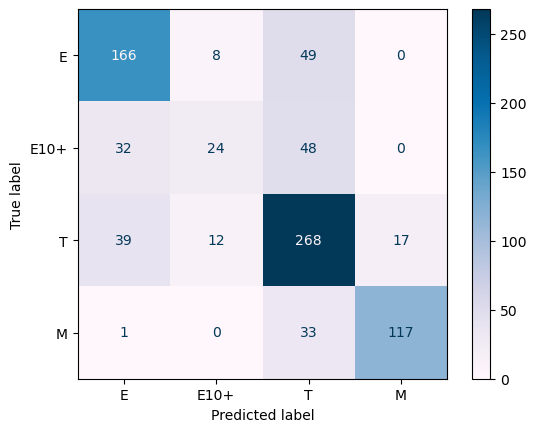

In [23]:
'''
Volvemos a imprimir los resultados del mejor predictor
'''
print('\nResults on the test set:')
print(classification_report(y_true, y_pred))

y_true, y_pred = listOfRatings_test , mejorClasificadorESRB["{}".format(dfPredictores.iloc[0,0])][0].predict(listOfCaracteristicas_test)
cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot(cmap='PuBu')

# Paso 3: Clasificador de Reviews
Una vez obtenida la clasificación por edades, seguiremos buscando esa recomendación de juego a partir de un anális introducido por el usuario. Trataremos de hallar la califición adecuada a dicho texto y, de nuevo, buscar el ejemplo más cercano.

In [24]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string
import nltk

nltk.download('words')        #Descomentar si surge un error
nltk.download('wordnet')      #Descomentar si surge un error
# nltk.download('stopwords')    #Descomentar si surge un error
# nltk.download('punkt')        #Descomentar si surge un error

[nltk_data] Downloading package words to /home/julen/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /home/julen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Para el clasificador de reviews, debemos dividir nuestros datos, ahora en _train_, _test_ y _validación_, pero esta vez de forma manual.

In [25]:
#Creamos una 'serie' donde guardamos todos los datos del diccionario original y asi poder realizar la partición
datosTrainValidacion = pd.Series(listaJuegosTrain)
listaJuegosTrainReviews, listaJuegosValidacionReviews = split([i.to_dict() for i in split(datosTrainValidacion,train_size=0.8)],shuffle=True,random_state=42)
listaJuegosTrainReviews = listaJuegosTrainReviews[0]
listaJuegosValidacionReviews = listaJuegosValidacionReviews[0]

#Borramos la variable innecesaria
del datosTrainValidacion

print("Cantidad de juegos en el conjunto TRAIN: {}  //  VALIDACION: {}  //  TEST: {}".format(len(listaJuegosTrainReviews),len(listaJuegosValidacionReviews),len(listaJuegosTest)))

Cantidad de juegos en el conjunto TRAIN: 3688  //  VALIDACION: 922  //  TEST: 814


Así pues, los datos quedan nuevamente divididos de la siguiente forma:

- `listaJuegosTrainReviews` un _67.99%_ del total
- `listaJuegosValidacionReviews` un _17%_ del total
- `listaJuegosTest` un _15.01%_ del total

## Preprocesamiento de arrays

Antes de proceder a la extracción de las palabras lo que debemos hacer es un preprocesamiento de los arrays para dejarlos "limpios". Lo que debemos hacer es lo siguiente:

- **Non-English Words Removal**: Se eliminan todas aquellas palabras que no sean en inglés.

- **Stop word removal and Removal of non-words**: Se eliminan palabras como  "and," "the," o "of," que son muy comunes en las frases en inglés y no aportan información sobre la clasificación. Además, se elimina todo lo que no son palabras, números y símbolos de puntuación. Todos los tipos de espacios (tabuladores, nueva línea y espacios) se convierten en un único espacio.

- **Stemming**: Palabras que tienen el mismo significado pero final diferente se ajustan para que tengan la misma forma. Por ejemplo, "include", "includes," e "included," todas se representan como "include." Además todas las palabras se pasan a minúsculas.

In [26]:
def analizarReviews(arrayOfReviews,arrayOfScores,finalArrayOfReviews,finalArrayOfScores):
    '''
    :arrayOfReviews: Un array donde cada elemento se trata de un string entero que es un review
    :arrayOfScores: Mismo array que reviews, solamente que cada elemento se trata de la valoración de la misma
    :finalArrayOfReviews: Array donde se guardan en cada elemento la review procesada
    :finalArrayOfScores: Array donde se guardan los scores finales, realizando asi una limpieza de aquellos scores asociados a reviews no procesadas correctamente
    :Return: Devuelve los mismos arrays finales de reviews y scores con los nuevos valores
    '''
    stop = set(stopwords.words('english') + list(string.punctuation+'¡¿'))
    lemmatizer = WordNetLemmatizer()
    porter = PorterStemmer()
    for i in range(len(arrayOfReviews)):
        '''
        Non-English Words Removal   //  No se usa ya que tarda demasiado tiempo
        '''
        # words = set(nltk.corpus.words.words())
        # sentence = " ".join(w for w in nltk.wordpunct_tokenize(sentence) if w.lower() in words or not w.isalpha())
        '''
        Stop word removal and Removal of non-words
        '''
        sentence = [i for i in word_tokenize(arrayOfReviews[i]) if i not in stop]
        '''
        Stemming  //  Lemmatizacion
        '''
        sentence = [lemmatizer.lemmatize(word) for word in sentence]
        sentence = [porter.stem(word) for word in sentence]
        '''
        Añadimos como oracion nueva
        '''
        if(sentence!=''):
            finalArrayOfReviews.append(sentence)
            finalArrayOfScores.append(arrayOfScores[i])
    return finalArrayOfReviews,finalArrayOfScores

In [27]:
def preprocesamientoReviews(listaJuegos,separacion):
    '''
    :listaJuegos: Introducir cualquiera de los diccionarios creados
    :separacion: Dividir los diccionarios para no saturar la memoria
    :Return: Devuelve un array con las frases procesadas
    '''
    finalArrayOfReviews = []
    finalArrayOfScores = []
    for i in range(separacion):
        dictToList = np.array([*dict(list(listaJuegos.items())[len(listaJuegos)//separacion*i:len(listaJuegos)//separacion*(i+1)]).values()])
        listOfReviews = []
        listOfScores = []
        for i in range(len(dictToList)): listOfReviews.append(dictToList[i].reviews[:,1])
        arrayOfReviews = [item for sublist in listOfReviews for item in sublist]
        for i in range(len(dictToList)): listOfScores.append(dictToList[i].reviews[:,0])
        arrayOfScores = [item for sublist in listOfScores for item in sublist]
        finalArrayOfReviews,finalArrayOfScores = analizarReviews(arrayOfReviews,arrayOfScores,finalArrayOfReviews,finalArrayOfScores)
    return finalArrayOfReviews,finalArrayOfScores

In [28]:
'''
En cada "parrafo" de codigo realizamos lo mismo en los conjuntos de train, validacion y test.
Se consigue unos arrays finales de reviews y scores.
Por otro lado, tambien se borran las variables innecesarias.

Tiempo de ejecucion de la celda aproximadamente 5 minutos
'''
reviewsTrainList,scoreTrain = preprocesamientoReviews(listaJuegosTrainReviews,6)
reviewsTrain = []
for sentence in reviewsTrainList:
    reviewsTrain.append(' '.join([str(n) for n in sentence]))
del reviewsTrainList, listaJuegosTrainReviews
scoreTrain = np.int32(np.array(scoreTrain))
print("Reviews TRAIN preprocesadas: {} / {}".format(len(reviewsTrain),scoreTrain.shape))
 
reviewsValidacionList,scoreValidacion = preprocesamientoReviews(listaJuegosValidacionReviews,2)
reviewsValidacion = []
for sentence in reviewsValidacionList:
    reviewsValidacion.append(' '.join([str(n) for n in sentence]))
del reviewsValidacionList, listaJuegosValidacionReviews
scoreValidacion = np.int32(np.array(scoreValidacion))
print("Reviews VALIDACION preprocesadas: {} / {}".format(len(reviewsValidacion),scoreValidacion.shape))

reviewsTestList,scoreTest = preprocesamientoReviews(listaJuegosTest,2)
reviewsTest = []
for sentence in reviewsTestList:
    reviewsTest.append(' '.join([str(n) for n in sentence]))
del reviewsTestList, sentence
scoreTest = np.int32(np.array(scoreTest))
print("Reviews TEST preprocesadas: {} / {}".format(len(reviewsTest),scoreTest.shape))

Reviews TRAIN preprocesadas: 128644 / (128644,)
Reviews VALIDACION preprocesadas: 30178 / (30178,)
Reviews TEST preprocesadas: 27884 / (27884,)


## Bag of Words - CountVectorizer

Una vez terminado el preprocesamiento, vamos a extraer las palabras más características. Vamos ha probar dos modelos distintos de extracciones, en este caso `CountVectorizer`. Este simplemente indica en binario si existe o no la palabra en el array.

### Paso 1: Extraer palabras mas características
Mediante el modulo de sklearn **text**, extraemos las _x_ palabras más repetidas en todos los conjuntos de reviews.

In [29]:
from sklearn.feature_extraction import text

def extraccionAtributosCount(nAtributos,reviewsTrain,reviewsValidacion,reviewsTest):
    '''
    :nAtributos: Numero de atributos que utilizaremos para extraer las 'n' mas importantes
    :reviewsTrain: Array donde se encuentran, en cada elemento, las reviews preprocesadas
    :reviewsValidacion: Array donde se encuentran, en cada elemento, las reviews preprocesadas
    :reviewsTest: Array donde se encuentran, en cada elemento, las reviews preprocesadas
    :Return: Devuelve arrays de train, validacion y test con las palabras mas repetidas extraidas
    '''
    vectorizer = text.CountVectorizer(strip_accents='ascii', analyzer='word', tokenizer=None, preprocessor=None, stop_words=None, max_features= nAtributos, binary=True) 
    '''
    Extraemos las palabras mas repetidas en TRAIN
    '''
    #Realizamos fit con los valores de train
    train_data_features = vectorizer.fit_transform(reviewsTrain)
    train_data_features = train_data_features.toarray()
    '''
    Extraemos las palabras mas repetidas en VALIDACION
    '''
    #Realizamos transform con el fit ya realizado anteriormente
    validation_data_features = vectorizer.transform(reviewsValidacion)
    validation_data_features = validation_data_features.toarray()
    '''
    Extraemos las palabras mas repetidas en TEST
    '''
    #Realizamos transform con el fit ya realizado anteriormente
    test_data_features = vectorizer.transform(reviewsTest)
    test_data_features = test_data_features.toarray()

    return train_data_features,validation_data_features,test_data_features,vectorizer

### Paso 2: Calcular accuracy
Como bien se menciona en el título, calcularemos el accuracy para comprobar si se ha hecho correctamente el predictor.

Antes de nada mencionar que utilizamos una _"normalización"_ de lo calculado por las siguientes razones:

- Se tratan de valoraciones subjetivas por lo que no existe una distinción clara entre clases.
- Por la misma razón, al ser 10 notas (clases) distintas, la diferencia entre valorar un juego como 8 o como 9 es muy pequeña y dificil de distinguir, así que consideraremos como correcta una predicción que se desvíe como mucho dos punto de la nota real.

In [30]:
def normalizarScore(real,calculado):
    '''
    :real: Array con los valores reales de las reviews
    :calculado: Array con los valores calculados de las reviews
    :Return: Devuelve un array con los scores normalizados
    '''
    for i in range(len(real)):
        if((real[i]-2<=calculado[i]) and ((real[i]+2>=calculado[i]))):
            calculado[i] = real[i]
    return calculado

Dataset reviews
Resultados con Naïve Bayes
Mejor Atributos: 1500
Precisión en train: [0.79088026 0.80948198 0.81492335]
Precisión en validacion: [0.79388959 0.8079727  0.81178342]
Precisión en test: [0.79450581 0.81078755 0.81491178]


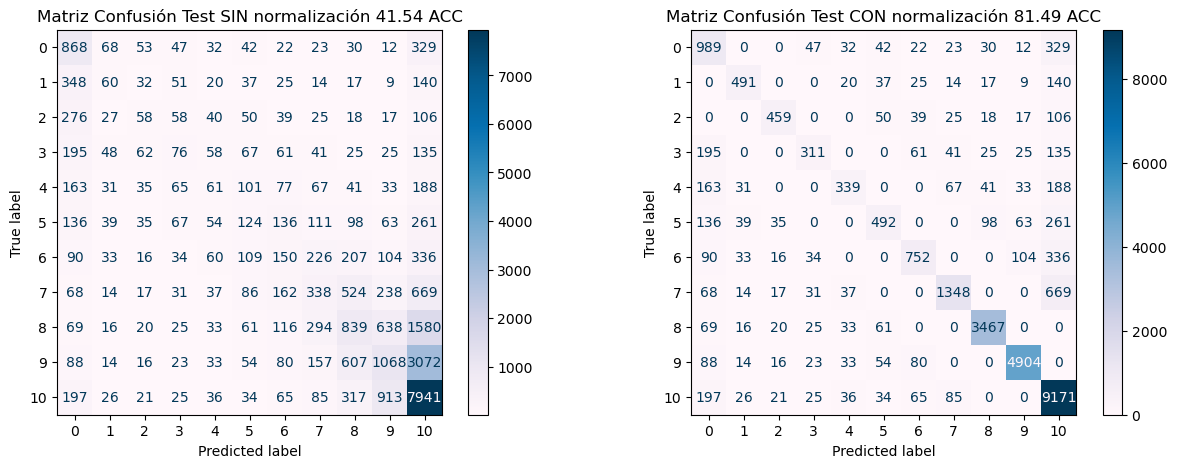

In [31]:
from sklearn import naive_bayes

listaAtributos = [500,1000,1500]
mejoresAtributosNB = {'accTrain': np.array([]), 'accValidacion': np.array([]), 'accTest': np.array([]), 'bestAcc': -np.Inf, 'bestAtributos': None}

for nAtributos in listaAtributos:
    train_data_features,validation_data_features,test_data_features,vectorizer = extraccionAtributosCount(nAtributos,reviewsTrain,reviewsValidacion,reviewsTest)
    # Crea el modelo
    multinb = naive_bayes.MultinomialNB()

    # Lo entrenamos
    multinb.fit(train_data_features,scoreTrain)

    # Obtenemos las salidas para las instancias de train 
    salida =  multinb.predict(train_data_features)
    # Obtenemos la precisión en train mediante accuracy_score (accTrain)
    mejoresAtributosNB['accTrain'] = np.append(mejoresAtributosNB['accTrain'],accuracy_score(scoreTrain,normalizarScore(scoreTrain,salida)))

    # Obtenemos las salidas para validacion 
    salida =  multinb.predict(validation_data_features)
    # Obtenemos la precisión en validacion mediante accuracy_score (accValidacion)
    mejoresAtributosNB['accValidacion'] = np.append(mejoresAtributosNB['accValidacion'],accuracy_score(scoreValidacion,normalizarScore(scoreValidacion,salida)))

    # Obtenemos las salidas para test 
    salida =  multinb.predict(test_data_features)
    # Obtenemos la precisión en test mediante accuracy_score (accTest)
    mejoresAtributosNB['accTest'] = np.append(mejoresAtributosNB['accTest'],accuracy_score(scoreTest,normalizarScore(scoreTest,salida)))
    
    if(mejoresAtributosNB['bestAcc'] < mejoresAtributosNB['accValidacion'][-1]):
        mejoresAtributosNB['bestAcc'] = mejoresAtributosNB['accValidacion'][-1]
        mejorClasificadorReviews['multiNBCount'][1] = mejoresAtributosNB['accTest'][-1]
        mejoresAtributosNB['bestAtributos'] = nAtributos
        mejorClasificadorReviews['multiNBCount'][0] = multinb
        mejorClasificadorReviews['vectorizer'] = vectorizer

# Imprimimos los resultados obtenidos
print("Dataset " + 'reviews')
print("Resultados con Naïve Bayes")
print("Mejor Atributos: {}".format(mejoresAtributosNB['bestAtributos']))
print("Precisión en train: {}".format(mejoresAtributosNB['accTrain']))
print("Precisión en validacion: {}".format(mejoresAtributosNB['accValidacion']))
print("Precisión en test: {}".format(mejoresAtributosNB['accTest']))

test_data_features = mejorClasificadorReviews['vectorizer'].transform(reviewsTest)
test_data_features = test_data_features.toarray()

salida =  mejorClasificadorReviews['multiNBCount'][0].predict(test_data_features)

fig, ax = plt.subplots(1,2, figsize=(15,5))
class_names = np.unique(scoreTrain)

ax[0].set_title("Matriz Confusión Test SIN normalización {:.2f} ACC".format(100*accuracy_score(scoreTest,salida)))
cm = confusion_matrix(scoreTest, salida, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot(ax=ax[0],cmap='PuBu')

ax[1].set_title("Matriz Confusión Test CON normalización {:.2f} ACC".format(100*recall_score(scoreTest,normalizarScore(scoreTest,salida),average='weighted')))
cm = confusion_matrix(scoreTest, normalizarScore(scoreTest,salida), labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot(ax=ax[1],cmap='PuBu')

# del reviewsTrain, reviewsValidacion, reviewsTest, scoreTrain, scoreValidacion, scoreTest, train_data_features, validation_data_features, test_data_features, multinb, nAtributos, vectorizer

Como podemos comprobar, tenemos una gran cantidad de datos, y como hemos mencionado anteriormente, es más que necesario realizar una _"normalización"_ para obtener un porcentaje decente de acierto. Mediante este método, aumentamos el doble la cantidad de datos acertados. Hemos utilizado un _accuracy-score_ para obtener el porcentaje a utilizar.

Con un total de **81,5** de acierto podemos obtener las siguientes conclusiones a partir de la matriz de confusión:

- Existe un mayor porcentaje de acierto en los scores _0_ y _10_. Esto no es algo sorprendente ya los casos extremos siempre son más facilmente identificables.
- Por otro lado, aquellos que se encuentran en "puntos muertos", como valoraciones entre el _3_ y el _7_ no devuelven un porcentaje de acierto especialmente alto. Nuevamente, podemos achacar esto a la complejidad intrínseca de nuetro problema, que se trata de predecir sobre una valoración ya de entrada subjetiva y voluble

## Bag of Words - TfidVectorizer

Volvemos a extraer las palabras más características. En este caso mediante la función `TfidVectorizer`. Esta, al contrario que la anterior, importa los pesos, dando así mas importancia a aquellas palabras repetidas y no simplemente si existen o no.

### Paso 1: Extraer palabras mas características
Mediante el modulo de sklearn **text**, extraemos las _x_ palabras más repetidas en todos los conjuntos de reviews.

In [32]:
from sklearn.feature_extraction import text

def extraccionAtributosTfid(nAtributos,reviewsTrain,reviewsValidacion,reviewsTest):
    '''
    :nAtributos: Numero de atributos que utilizaremos para extraer las 'n' mas importantes
    :reviewsTrain: Array donde se encuentran, en cada elemento, las reviews preprocesadas
    :reviewsValidacion: Array donde se encuentran, en cada elemento, las reviews preprocesadas
    :reviewsTest: Array donde se encuentran, en cada elemento, las reviews preprocesadas
    :Return: Devuelve arrays de train, validacion y test con las palabras mas repetidas extraidas
    '''
    tfid = text.TfidfVectorizer(strip_accents='ascii', analyzer='word', tokenizer=None, preprocessor=None, stop_words=None, max_features= nAtributos, binary=True)
    '''
    Extraemos las palabras mas repetidas en TRAIN
    '''
    #Realizamos fit con los valores de train
    train_data_features = tfid.fit_transform(reviewsTrain)
    train_data_features = train_data_features.toarray()
    '''
    Extraemos las palabras mas repetidas en VALIDACION
    '''
    #Realizamos transform con el fit ya realizado anteriormente
    validation_data_features = tfid.transform(reviewsValidacion)
    validation_data_features = validation_data_features.toarray()
    '''
    Extraemos las palabras mas repetidas en TEST
    '''
    #Realizamos transform con el fit ya realizado anteriormente
    test_data_features = tfid.transform(reviewsTest)
    test_data_features = test_data_features.toarray()

    return train_data_features,validation_data_features,test_data_features,tfid

### Paso 2: Calcular accuracy
Como bien se menciona en el título, calcularemos el accuracy para comprobar si se ha hecho correctamente el predictor.

Antes de nada mencionar que utilizamos una _"normalización"_ de lo calculado por las siguientes razones:

- Se tratan de valoraciones subjetivas por lo que no existe una distinción clara entre clases.
- Por la misma razón, al ser 10 notas (clases) distintas, la diferencia entre valorar un juego como 8 o como 9 es muy pequeña y dificil de distinguir, así que consideraremos como correcta una predicción que se desvíe como mucho dos punto de la nota real.

In [33]:
def normalizarScore(real,calculado):
    '''
    :real: Array con los valores reales de las reviews
    :calculado: Array con los valores calculados de las reviews
    :Return: Devuelve un array con los scores normalizados
    '''
    for i in range(len(real)):
        if((real[i]-2<=calculado[i]) and ((real[i]+2>=calculado[i]))):
            calculado[i] = real[i]
    return calculado

Dataset reviews
Resultados con Naïve Bayes
Mejor Atributos: 1500
Precisión en train: [0.70862224 0.72685862 0.73571251]
Precisión en validacion: [0.71724435 0.73437604 0.739214  ]
Precisión en test: [0.71858413 0.73497346 0.74103428]


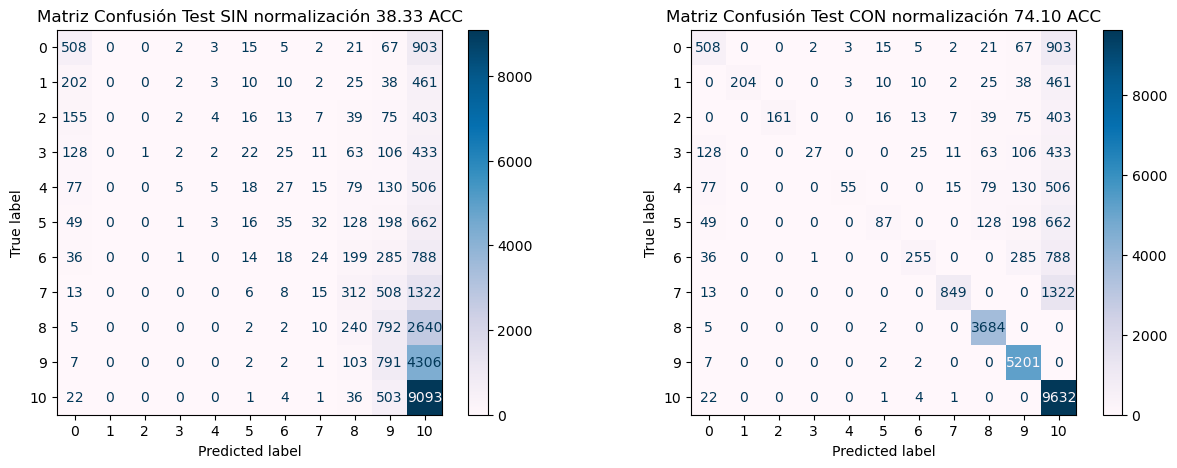

In [34]:
from sklearn import naive_bayes

listaAtributos = [500,1000,1500]
mejoresAtributosNB = {'accTrain': np.array([]), 'accValidacion': np.array([]), 'accTest': np.array([]), 'bestAcc': -np.Inf, 'bestAtributos': None}

for nAtributos in listaAtributos:
    train_data_features,validation_data_features,test_data_features,tfid = extraccionAtributosTfid(nAtributos,reviewsTrain,reviewsValidacion,reviewsTest)
    # Crea el modelo
    multinb = naive_bayes.MultinomialNB()

    # Lo entrenamos
    multinb.fit(train_data_features,scoreTrain)

    # Obtenemos las salidas para las instancias de train 
    salida =  multinb.predict(train_data_features)
    # Obtenemos la precisión en train mediante accuracy_score (accTrain)
    mejoresAtributosNB['accTrain'] = np.append(mejoresAtributosNB['accTrain'],accuracy_score(scoreTrain,normalizarScore(scoreTrain,salida)))

    # Obtenemos las salidas para validacion 
    salida =  multinb.predict(validation_data_features)
    # Obtenemos la precisión en validacion mediante accuracy_score (accValidacion)
    mejoresAtributosNB['accValidacion'] = np.append(mejoresAtributosNB['accValidacion'],accuracy_score(scoreValidacion,normalizarScore(scoreValidacion,salida)))

    # Obtenemos las salidas para test 
    salida =  multinb.predict(test_data_features)
    # Obtenemos la precisión en test mediante accuracy_score (accTest)
    mejoresAtributosNB['accTest'] = np.append(mejoresAtributosNB['accTest'],accuracy_score(scoreTest,normalizarScore(scoreTest,salida)))
    
    if(mejoresAtributosNB['bestAcc'] < mejoresAtributosNB['accValidacion'][-1]):
        mejoresAtributosNB['bestAcc'] = mejoresAtributosNB['accValidacion'][-1]
        mejorClasificadorReviews['multiNBTfid'][1] = mejoresAtributosNB['accTest'][-1]
        mejoresAtributosNB['bestAtributos'] = nAtributos
        mejorClasificadorReviews['multiNBTfid'][0] = multinb
        mejorClasificadorReviews['tfid'] = tfid

# Imprimimos los resultados obtenidos
print("Dataset " + 'reviews')
print("Resultados con Naïve Bayes")
print("Mejor Atributos: {}".format(mejoresAtributosNB['bestAtributos']))
print("Precisión en train: {}".format(mejoresAtributosNB['accTrain']))
print("Precisión en validacion: {}".format(mejoresAtributosNB['accValidacion']))
print("Precisión en test: {}".format(mejoresAtributosNB['accTest']))

test_data_features = mejorClasificadorReviews['tfid'].transform(reviewsTest)
test_data_features = test_data_features.toarray()

salida =  mejorClasificadorReviews['multiNBTfid'][0].predict(test_data_features)

fig, ax = plt.subplots(1,2, figsize=(15,5))
class_names = np.unique(scoreTrain)

ax[0].set_title("Matriz Confusión Test SIN normalización {:.2f} ACC".format(100*accuracy_score(scoreTest,salida)))
cm = confusion_matrix(scoreTest, salida, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot(ax=ax[0],cmap='PuBu')

ax[1].set_title("Matriz Confusión Test CON normalización {:.2f} ACC".format(100*recall_score(scoreTest,normalizarScore(scoreTest,salida),average='weighted')))
cm = confusion_matrix(scoreTest, normalizarScore(scoreTest,salida), labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot(ax=ax[1],cmap='PuBu')

# del reviewsTrain, reviewsValidacion, reviewsTest, scoreTrain, scoreValidacion, scoreTest, train_data_features, validation_data_features, test_data_features, multinb, nAtributos, vectorizer

Al igual que en la extracción anterior, hemos tenido que realizar una _"normalización"_ de los resultados. Mediante este método, aumentamos el doble la cantidad de datos acertados. Hemos utilizado un _accuracy-score_ para obtener el porcentaje a utilizar.

Con un total de **74,2** de acierto podemos obtener las siguientes conclusiones a partir de la matriz de confusión:

- Es claramaente inferior al obtenido mediante el uso de `CountVectorizer`. Esto es debido principalmente a los pesos. Existen muchos tipos de reviews en cuanto a claridad, léxico utilizado, longitud,... Sobre todo, tenemos muchas reviews de clase _10_. Una gran cantidad de palabras se repiten por lo tanto en estas, al darles un peso estas discriminando a las demas. Existen menos reviews y por lo tanto menos posibilidades de que puedan haber tantas repeticiones de palabras.

# Paso 4: Recomendador Juegos

Como cuarto y último paso vamos a realizar el recomendador de videojuegos. Este se va ha dividir en 3 partes:

1. **Predicción de la valoración de las reviews** ➞ Mediante el clasificador realizado, obtendremos la nota relacionada a dicha _review_.
2. **Predicción de los scores ESRBs** ➞ Obtendremos el score relacionado con las características introducidas usando el mejor predictor calculado anteriormente.
3. **Recomendar juegos** ➞ Realizaremos la recomendación final. Este tiene su propio predictor el cual explicaremos mas adelante.

## Paso 4.1: Predicción de las valoraciones de las reviews

Crearemos una función mediante la cual se introducirá la _review_ como un string y se obtendrá la valoración final.

In [53]:
def predictValReviews(review):
    '''
    :review: String donde se encuentra la review a analizar
    :Return: Devuelve el número entero el cual es la predicción de la review
    '''
    review,extra = analizarReviews([review],[None],[],[])
    reviewList = []
    for sentence in review:
        reviewList.append(' '.join([str(n) for n in sentence]))
    if(mejorClasificadorReviews['multiNBCount'][1] > mejorClasificadorReviews['multiNBTfid'][1]):
        reviewList = mejorClasificadorReviews['vectorizer'].transform(reviewList)
        reviewList = reviewList.toarray()
        salida = mejorClasificadorReviews['multiNBCount'][0].predict(reviewList)[0]
    else:
        reviewList = mejorClasificadorReviews['tfid'].transform(reviewList)
        reviewList = reviewList.toarray()
        salida = mejorClasificadorReviews['multiNBTfid'][0].predict(reviewList)[0]
    return salida

## Paso 4.2: Predicción de los scores ESRBs

Al igual que en el paso anterior, crearemos una función que realice el mismo trabajo solo que en esta ocasión con las variables ESRB.

In [36]:
'''
En esta celda solamente extraeremos el mejor predictor de ESRBs respecto al porcentaje de acierto.
'''
bestPredict = mejorClasificadorESRB["{}".format(dfPredictores.iloc[0,0])][0]
bestPredict

SVC(C=2, decision_function_shape='ovo', gamma=3, probability=True,
    random_state=2)

In [37]:
def predictValESRB(caracteristicasESRB):
    '''
    :caracteristicasESRB: Array donde se encuentran las características binarias respecto a cada variable
    :Return: Devuelve el número entero el cual es la predicción de las caracteristicas
    '''
    caracteristicasESRB = scESRB.transform([caracteristicasESRB])
    caracteristicasESRB = pcaESRB.transform(caracteristicasESRB)
    salida = bestPredict.predict(caracteristicasESRB)[0]
    return salida

## Paso 4.3: Recomendar juegos

Este paso es mucho mas extenso que los anteriores ya que tenemos que realizar unos tratamientos de datos previos y un propio predictor para este paso final.

### Paso 4.3.1: Preprocesamiento de datos

En primer lugar, usaremos el conjunto `listaJuegos` original, no _train_ ni _test_. La razón es muy simple. No vamos a crear ningún modelo sobre el que medir como de bueno o malo es prediciendo. Lo que necesitamos es tener todos los juegos que poseemos como posibles clases a obtener. Vamos a crear dos array _X_ e _y_ los cuales van a tener la siguiente estructura:

- **X_datosJuegos**
    - **fechaSalida** ➞ (INT) Guardaremos el año de salida del juego.
    - **genero** ➞ (STR) Guardaremos el genero mas propio del juego.
    - **portable** ➞ (BINARIO) Si el juego se encuentra en una plataforma portable o no.
    - **esrb.rating** ➞ (STR) Guardamos el _rating_ del juego
    - **score** ➞ (INT) Guardaremos la valoración del juego mediante una media aritmetica entre el _metaScore_ y _userScore_.
    - **multijugador** ➞ (BINARIO) Si el juego tiene capacidad multijugadora o no.
    - **online** ➞ (BINARIO) Si el juego tiene capacidad de jugar en linea o no.
- **Y_datosJuegos**
    - **nombreJuego** ➞ (STR) Simplemente guardamos el nombre del propio juego.

En cuanto a la variable **genero** y **esrb.rating**, estas no pueden ser variables que contengan texto, por lo tanto vamos ha realizar un transformación mediante _LabelEncoder_ como hemos hecho previamente con los mismos ratings.

In [38]:
'''
Extraemos todos los tipos de generos existentes mediante un fichero tambien usado en la lectura de los datos
'''
generos = np.loadtxt('datos/generos.txt',delimiter=',',dtype=str)
leGeneros = LabelEncoder().fit(generos)

In [39]:
'''
Realizamos la extracción de los datos
'''
dictToList = np.array([*dict(list(listaJuegos.items())).values()])  #Lista con todos los juegos
X_datosJuegos = []
Y_datosJuegos = []
#Itero sobre la lista para extraer los arrays de características (X) y de ratings (Y)
for i in range(len(dictToList)):
    #Tenemos cuidado sobre estos valores para no tener fallos como hemos echo en el paso 3
    if(dictToList[i].esrb.rating == 'K-A'):
        dictToList[i].esrb.rating = 'E'
    elif(dictToList[i].esrb.rating == 'AO'):
        dictToList[i].esrb.rating = 'M'

    if(dictToList[i].esrb.rating != 'RP' and dictToList[i].fechaSalida>0):
        X_datosJuegos.append([dictToList[i].fechaSalida,leGeneros.transform([dictToList[i].genero])[0],dictToList[i].portable,
                        leEsrb.transform([dictToList[i].esrb.rating])[0],np.int(np.round(np.mean([dictToList[i].metaScore/10,dictToList[i].userScore]))),
                        dictToList[i].multijugador,dictToList[i].online])
        Y_datosJuegos.append([dictToList[i].nombre])

X_datosJuegos = np.array(X_datosJuegos)
Y_datosJuegos = np.array(Y_datosJuegos)

Una vez extraidos todos lo datos, vamos a realizar una estandarización de todos ellos para mejorar la ejecución. Usaremos el mismo proceso que anteriormente.

In [40]:
'''
Realizamos la estandarización
'''
scJuegos = StandardScaler()
X_datosJuegos = scJuegos.fit_transform(X_datosJuegos)

### Paso 4.3.2: Construcción predictor

Seguidamente, como es obvio, necesitamos trabajar con estos datos. Para ello, vamos a realizar un aprendizaje **NO supervisado** utilizando un predictor como _KMeans_. Nosotros no necesitamos acertar ningún tipo de dato ni obtener el mejor porcentaje de ningún tipo. Lo que verdaderamente necesitamos es que mediante los **clusters** se agrupen juegos de características similares, para de esta manera poder recomendar juegos correctamente.

Una vez que el predictor esté construido, nosotros mediante los datos introducidos, obtendremos a qué cluster más se asemeja. Daremos como salida, como recomendaciones, aquellos juegos que se encuentren dentro de ese cluster.

In [41]:
'''
KMEANS
'''
from sklearn.cluster import KMeans

#Por conveniencia decidimos que existen un cuarto de clusters del total de cantidad de juegos
recomendador = KMeans(n_clusters=np.int(len(Y_datosJuegos)/2), random_state=1)
recomendador = recomendador.fit(X_datosJuegos,Y_datosJuegos)

### Paso 4.3.3: Definir función predictora

En este paso construiremos una función simple en la cual introduciremos los datos de los juegos que queremos recomendar y devolveremos una tabla donde se encuentren estos.

In [42]:
'''
Creamos una tabla pandas donde podremos ver de manera mas rapida que juego pertenece a que cluster
'''
dfClustersJuegos = pd.DataFrame({'clusters' : recomendador.labels_, 'juegos' : Y_datosJuegos.flatten()})

In [43]:
def recomendadorJuegos(caracteristicas):
    '''
    :caracteristicas: Array donde se almacenan las características que nos interesan
    :Return: Devolución de una tabla pandas donde se almacenen los juegos mas parecidos
    '''
    dfRecom = pd.DataFrame(columns=['Nombre','Plataforma','Desarrolladora','Sinopsis'])
    caracteristicas = np.array(caracteristicas)

    #Realizamos los cambios de variables pertinentes
    caracteristicas[1] = leGeneros.transform([caracteristicas[1]])[0]
    caracteristicas[3] = leEsrb.transform([caracteristicas[3]])[0]

    #Realizamos la estandarización pertinente
    caracteristicas = scJuegos.transform([caracteristicas])
    recom = recomendador.predict(caracteristicas)

    #Construimos la tabla
    for i in recom:
        j = listaJuegos["{}".format(dfClustersJuegos[dfClustersJuegos.clusters==i].values[0,1])]
        dfRecom.loc[i] = [j.nombre, j.plataforma, j.desarrollador, j.sinopsis]

    return dfRecom

## Paso 4.4 Recomendador

Finalmente, el usuario introducirá los datos referentes a su juego para recibir su recomendación.

In [44]:
caracteristicasESRB = np.loadtxt('datos/caracteristicas_esrb.txt',delimiter=',',dtype=str)

def pedirCaracteristicasESRB():
    carESRB = np.zeros_like(caracteristicasESRB,dtype=int)

    #VIOLENCE
    aux = int(input("¿Quiere que su juego se juego tenga VIOLENCIA? (0 = NO // 1 = SI): "))
    while(aux != 0 and aux != 1):
        aux = int(input("Introduzca un valor correcto porfavor (0 = NO // 1 = SI): "))
    if(aux == 1):
        aux = int(input("¿Quiere que sea 'Entre Personas' // 'Fantasia' // 'Dibujos' // 'Animado'? (0 // 1 // 2 // 3): "))
        while(aux != 0 and aux != 1 and aux != 2 and aux != 3):
            aux = int(input("Introduzca un valor correcto porfavor (0 // 1 // 2 // 3): "))
        if(aux == 0):
            aux2 = int(input("¿Quiere que sea Referencia o Existente? (0 = Referencia // 1 = Existente): "))
            while(aux2 != 0 and aux2 != 1):
                aux2 = int(input("Introduzca un valor correcto porfavor (0 = Referencia // 1 = Existente): "))
            if(aux2 == 0):
                carESRB[4] = 1
            elif(aux2 == 1):
                aux2 = int(input("¿Quiere que sea 'Normal' // 'Suave' // 'Intenso' // 'Realista' (0 // 1 // 2 // 3): "))
                while(aux2 != 0 and aux2 != 1 and aux2 != 2 and aux2 != 3):
                    aux2 = int(input("Introduzca un valor correcto porfavor (0 // 1 // 2 // 3): "))
                carESRB[aux2] = 1
        elif(aux == 1):
            aux2 = int(input("¿Quiere que sea Normal o Leve? (0 = Normal // 1 = Leve): "))
            while(aux2 != 0 and aux2 != 1):
                aux2 = int(input("Introduzca un valor correcto porfavor (0 = Normal // 1 = Leve): "))
            if(aux2 == 0):
                carESRB[38] = 1
            elif(aux2 == 1):
                carESRB[39] = 1
        elif(aux == 2):
            aux2 = int(input("¿Quiere que sea Normal o Leve? (0 = Normal // 1 = Leve): "))
            while(aux2 != 0 and aux2 != 1):
                aux2 = int(input("Introduzca un valor correcto porfavor (0 = Normal // 1 = Leve): "))
            if(aux2 == 0):
                carESRB[40] = 1
            elif(aux2 == 1):
                carESRB[41] = 1
        elif(aux == 3):
            aux2 = int(input("¿Quiere que sea Normal o Leve? (0 = Normal // 1 = Leve): "))
            while(aux2 != 0 and aux2 != 1):
                aux2 = int(input("Introduzca un valor correcto porfavor (0 = Normal // 1 = Leve): "))
            if(aux2 == 0):
                carESRB[42] = 1
            elif(aux2 == 1):
                carESRB[43] = 1
    
    #ALCOHOL
    aux = int(input("¿Quiere que su juego se juego tenga ALCOHOL? (0 = NO // 1 = SI): "))
    while(aux != 0 and aux != 1):
        aux = int(input("Introduzca un valor correcto porfavor (0 = NO // 1 = SI): "))
    if(aux == 1):
        aux = int(input("¿Quiere que sea Referencia o Uso? (0 = Referencia // 1 = Uso): "))
        while(aux != 0 and aux != 1):
            aux = int(input("Introduzca un valor correcto porfavor (0 = Referencia // 1 = Uso): "))
        if(aux == 0):
            carESRB[6] = 1
        elif(aux == 1):
            carESRB[5] = 1
    
    #TOBACCO
    aux = int(input("¿Quiere que su juego se juego tenga TABACO? (0 = NO // 1 = SI): "))
    while(aux != 0 and aux != 1):
        aux = int(input("Introduzca un valor correcto porfavor (0 = NO // 1 = SI): "))
    if(aux == 1):
        aux = int(input("¿Quiere que sea Referencia o Uso? (0 = Referencia // 1 = Uso): "))
        while(aux != 0 and aux != 1):
            aux = int(input("Introduzca un valor correcto porfavor (0 = Referencia // 1 = Uso): "))
        if(aux == 0):
            carESRB[11] = 1
        elif(aux == 1):
            carESRB[10] = 1
    
    #DROGAS
    aux = int(input("¿Quiere que su juego se juego tenga DROGAS? (0 = NO // 1 = SI): "))
    while(aux != 0 and aux != 1):
        aux = int(input("Introduzca un valor correcto porfavor (0 = NO // 1 = SI): "))
    if(aux == 1):
        aux = int(input("¿Quiere que sea Referencia o Uso? (0 = Referencia // 1 = Uso): "))
        while(aux != 0 and aux != 1):
            aux = int(input("Introduzca un valor correcto porfavor (0 = Referencia // 1 = Uso): "))
        if(aux == 0):
            carESRB[13] = 1
        elif(aux == 1):
            carESRB[12] = 1
    
    if(carESRB[5]==1 and carESRB[10]==1):
        carESRB[7] = 1
        carESRB[5] = 0
        carESRB[10] = 0
    
    if(carESRB[6]==1 and carESRB[11]==1):
        carESRB[8] = 1
        carESRB[6] = 0
        carESRB[11] = 0

    if(carESRB[6]==1 and carESRB[13]==1):
        carESRB[9] = 1
        carESRB[6] = 0
        carESRB[13] = 1
    
    #SUGGESTIVE
    aux = int(input("¿Quiere que su juego se juego tenga TEMAS SUGESTIVOS (racismo,xenofobia,...)? (0 = NO // 1 = SI): "))
    while(aux != 0 and aux != 1):
        aux = int(input("Introduzca un valor correcto porfavor (0 = NO // 1 = SI): "))
    if(aux == 1):
        aux = int(input("¿Quiere que sea 'Normal' // 'Suave'? (0 = 'Normal' // 1 = 'Suave'): "))
        while(aux != 0 and aux != 1):
            aux = int(input("Introduzca un valor correcto porfavor (0 = 'Normal' // 1 = 'Suave'): "))
        if(aux == 0):
            carESRB[14] = 1
        elif(aux == 1):
            carESRB[15] = 1
    
    #LYRICS
    aux = int(input("¿Quiere que su juego se juego tenga CANCIONES CON MALAS PALABRAS? (0 = NO // 1 = SI): "))
    while(aux != 0 and aux != 1):
        aux = int(input("Introduzca un valor correcto porfavor (0 = NO // 1 = SI): "))
    if(aux == 1):
        aux = int(input("¿Quiere que sea 'Normal' // 'Suave' // 'Intenso'? (0 // 1 // 2): "))
        while(aux != 0 and aux != 1 and aux!=2):
            aux = int(input("Introduzca un valor correcto porfavor (0 // 1 // 2): "))
        if(aux == 0):
            carESRB[16] = 1
        elif(aux == 1):
            carESRB[17] = 1
        elif(aux == 2):
            carESRB[18] = 1
    
    #LANGUAGE
    aux = int(input("¿Quiere que su juego se juego tenga INSULTOS? (0 = NO // 1 = SI): "))
    while(aux != 0 and aux != 1):
        aux = int(input("Introduzca un valor correcto porfavor (0 = NO // 1 = SI): "))
    if(aux == 1):
        aux = int(input("¿Quiere que sea 'Normal' // 'Suave' // 'Intenso'? (0 // 1 // 2): "))
        while(aux != 0 and aux != 1 and aux!=2):
            aux = int(input("Introduzca un valor correcto porfavor (0 // 1 // 2): "))
        if(aux == 0):
            carESRB[19] = 1
        elif(aux == 1):
            carESRB[20] = 1
        elif(aux == 2):
            carESRB[21] = 1
    
    #GAMBLING
    aux = int(input("¿Quiere que su juego se juego tenga APUESTAS? (0 = NO // 1 = SI): "))
    while(aux != 0 and aux != 1):
        aux = int(input("Introduzca un valor correcto porfavor (0 = NO // 1 = SI): "))
    if(aux == 1):
        aux = int(input("¿Quiere que sea Real o Ficticio? (0 = Real // 1 = Ficticio): "))
        while(aux != 0 and aux != 1):
            aux = int(input("Introduzca un valor correcto porfavor (0 = Real // 1 = Ficticio): "))
        if(aux == 0):
            carESRB[22] = 1
        elif(aux == 1):
            carESRB[23] = 1

    #SEXUAL
    aux = int(input("¿Quiere que su juego se juego tenga TEMAS SEXUALES? (0 = NO // 1 = SI): "))
    while(aux != 0 and aux != 1):
        aux = int(input("Introduzca un valor correcto porfavor (0 = NO // 1 = SI): "))
    if(aux == 1):
        aux = int(input("¿Quiere que se Mencione o Contenga escenas? (0 = Mencione // 1 = Contenga escenas): "))
        while(aux != 0 and aux != 1):
            aux = int(input("Introduzca un valor correcto porfavor (0 = Real // 1 = Ficticio): "))
        if(aux == 0):
            aux2 = int(input("¿Quiere que sea 'Normal' o 'Maduro'? (0 = 'Normal' // 1 = 'Maduro'): "))
            while(aux2 != 0 and aux2 != 1):
                aux2 = int(input("Introduzca un valor correcto porfavor (0 = 'Normal' // 1 = 'Maduro'): "))
            if(aux2 == 0):
                carESRB[24] = 1
            elif(aux2 == 1):
                carESRB[27] = 1
        elif(aux == 1):
            aux2 = int(input("¿Quiere que sea 'Normal' o 'Intenso'? (0 = 'Normal' // 1 = 'Intenso'): "))
            while(aux2 != 0 and aux2 != 1):
                aux2 = int(input("Introduzca un valor correcto porfavor (0 = 'Normal' // 1 = 'Intenso'): "))
            if(aux2 == 0):
                carESRB[25] = 1
            elif(aux2 == 1):
                carESRB[26] = 1
    
    #BLOOD // GORE
    aux = int(input("¿Quiere que su juego se juego tenga SANGRE Y/O GORE? (0 = NO // 1 = SI): "))
    while(aux != 0 and aux != 1):
        aux = int(input("Introduzca un valor correcto porfavor (0 = NO // 1 = SI): "))
    if(aux == 1):
        aux = int(input("¿Quiere que contenga Sangre o Sangre Y Gore? (0 = Sangre // 1 = Sangre Y Gore): "))
        while(aux != 0 and aux != 1):
            aux = int(input("Introduzca un valor correcto porfavor (0 = Sangre // 1 = Sangre Y Gore): "))
        if(aux == 0):
            aux2 = int(input("¿Quiere que sea 'Normal' o 'Animada'? (0 = 'Normal' // 1 = 'Animada'): "))
            while(aux2 != 0 and aux2 != 1):
                aux = int(input("Introduzca un valor correcto porfavor (0 = 'Normal' // 1 = 'Animada'): "))
            if(aux2 == 0):
                aux3 = int(input("¿Quiere que sea 'Normal' // 'Suave' // 'Intenso'? (0 // 1 // 2): "))
                while(aux3 != 0 and aux3 != 1 and aux3!=2):
                    aux3 = int(input("Introduzca un valor correcto porfavor (0 // 1 // 2): "))
                if(aux3 == 0):
                    carESRB[28] = 1
                elif(aux3 == 1):
                    carESRB[31] = 1
                elif(aux3 == 2):
                    carESRB[33] = 1
            elif(aux2 == 1):
                aux3 = int(input("¿Quiere que sea 'Normal' // 'Suave'? (0 = 'Normal' // 1 = 'Suave'): "))
                while(aux3 != 0 and aux3 != 1):
                    aux3 = int(input("Introduzca un valor correcto porfavor (0 = 'Normal' // 1 = 'Suave'): "))
                if(aux3 == 0):
                    carESRB[30] = 1
                elif(aux3 == 1):
                    carESRB[32] = 1
        elif(aux == 1):
            aux2 = int(input("¿Quiere que sea 'Normal' // 'Realista' // 'Animada'? (0 // 1 // 2): "))
            while(aux2 != 0 and aux2 != 1 and aux2 != 2):
                aux = int(input("Introduzca un valor correcto porfavor (0 // 1 // 2): "))
            if(aux2 == 0):
                carESRB[29] = 1
            elif(aux2 == 1):
                carESRB[34] = 1
            elif(aux2 == 2):
                carESRB[35] = 1
    
    #NUDITY
    aux = int(input("¿Quiere que su juego se juego tenga NUDISMOS? (0 = NO // 1 = SI): "))
    while(aux != 0 and aux != 1):
        aux = int(input("Introduzca un valor correcto porfavor (0 = NO // 1 = SI): "))
    if(aux == 1):
        aux = int(input("¿Quiere que sea Normal o Parcial? (0 = Normal // 1 = Parcial): "))
        while(aux != 0 and aux != 1):
            aux = int(input("Introduzca un valor correcto porfavor (0 = Normal // 1 = Parcial): "))
        if(aux == 0):
            carESRB[36] = 1
        elif(aux == 1):
            carESRB[37] = 1

    #EDUTAINMENT
    aux = int(input("¿Quiere que su juego sea EDUCATIVO? (0 = NO // 1 = SI): "))
    while(aux != 0 and aux != 1):
        aux = int(input("Introduzca un valor correcto porfavor (0 = NO // 1 = SI): "))
    if(aux == 1):
        carESRB[44] = 1
    
    #HUMOR
    aux = int(input("¿Quiere que su juego sea COMICO? (0 = NO // 1 = SI): "))
    while(aux != 0 and aux != 1):
        aux = int(input("Introduzca un valor correcto porfavor (0 = NO // 1 = SI): "))
    if(aux == 1):
        aux = int(input("¿Quiere que sea 'Crudo' (negro,verde,...) // 'Maduro' // 'Travesura'? (0 // 1 // 2): "))
        while(aux != 0 and aux != 1 and aux != 2):
            aux = int(input("Introduzca un valor correcto porfavor 0 // 1 // 2): "))
        if(aux == 0):
            carESRB[45] = 1
        elif(aux == 1):
            carESRB[46] = 1
        elif(aux == 2):
            carESRB[47] = 1
    
    return carESRB

In [45]:
'''
Creamos un array donde se pueden observar todos los generos existentes que se pueden usar
Ademas de leer las caracteristicas ESRB existentes por un fichero usado en la lectura de datos
'''
generosExistentes = ['action', 'actionadventure', 'adventure', 'arcade', 'driving', 'fantasy', 'general', 'miscellaneous', 'modern', 
                    'role-playing', 'sci-fi', 'simulation', 'sports', 'strategy']

def pedirDatosUsuario():
    '''
    :Return: Devolveremos un array con las características pedidas
    '''
    caracteristicas = np.zeros_like(X_datosJuegos[0],dtype='object')

    caracteristicas[0] = int(input("¿Cuando quiere que se haya estrenado su juego? (1996 <= x <= 2022): "))
    while(caracteristicas[0]<1996 or caracteristicas[0]>2022):
        caracteristicas[0] = int(input("Introduzca una fecha que se encuentre dentro del rango correcto porfavor (1996 <= x <= 2022): "))
    
    caracteristicas[1] = input("¿Que genero quiere que tenga su juego? (EN INGLES, escoja entre {}): ".format(generosExistentes))
    while(caracteristicas[1] not in generosExistentes):
        caracteristicas[1] = input("Introduzca un genero correcto porfavor (EN INGLES, escoja entre {}): ".format(generosExistentes))

    caracteristicas[2] = int(input("¿Quiere que su juego se pueda jugar de forma portable? (0 = NO // 1 = SI): "))
    while(caracteristicas[2] != 0 and caracteristicas[2] != 1):
        caracteristicas[2] = int(input("Introduzca un valor correcto porfavor (0 = NO // 1 = SI): "))

    caracteristicas[3] = pedirCaracteristicasESRB()
    caracteristicas[3] = predictValESRB(caracteristicas[3])
    
    review = input("Introduce la review que mas quiere que se asemeje a sus recomendaciones (EN INGLES): \n")
    caracteristicas[4] = predictValReviews(review)

    caracteristicas[5] = int(input("¿Quiere que su juego tenga opción multijugador? (0 = NO // 1 = SI): "))
    while(caracteristicas[5]!=0 and caracteristicas[5]!=1):
        caracteristicas[5] = int(input("Introsuxca un valor correcta para la caracteristica multijugador porfavor (0 = NO // 1 = SI): "))

    caracteristicas[6] = int(input("¿Quiere que su juego tenga opción de jugarlo en linea? (0 = NO // 1 = SI): "))
    while(caracteristicas[6]!=0 and caracteristicas[6]!=1):
        caracteristicas[6] = int(input("Introsuxca un valor correcta para la caracteristica online porfavor (0 = NO // 1 = SI): "))
    
    return caracteristicas

In [54]:
caracteristicas = pedirDatosUsuario()
print(caracteristicas)
recomendaciones = recomendadorJuegos(caracteristicas)
recomendaciones

[2005 'action' 0 'T' 10 0 1]


,Nombre,Plataforma,Desarrolladora,Sinopsis
1584,Battlefield 2,"[Dreamcast, PC]",Digital Illusions,"In Battlefield 2, players will choose to fight for one of three military superpowers: the United States, China, or the newly formed Middle East Coalition. Armed with the latest modern weaponry, players can take control of any of the game's 30+ vehicles to engage in major conflicts with over 100 players in some of the largest online battles on the PC. Battlefield 2 features immense, richly detailed, destructible environments, from city streets to remote forests, in some of the most notorious hot spots around the world. Each map in Battlefield 2 adjusts in scale to support the number of players in the world, providing the ideal vehicle-to-player ratio and an optimized game play experience. Enhanced team play features allow players to enter the action on the front lines as part of a formal squad, or work behind the scenes in Commander Mode to direct the strategic assaults of their teammates. With in-game success, players increase their rank from recruit all the way to General and unlock awards, including new weapons, vehicle decals, medals, and more. Additionally, Battlefield 2 showcases an all-new game engine and physics system to bring the modern battlefield to life like never before. The new material penetration feature measures weapons' ability to fire through barriers based on their composition and players will need to know the difference between concealment and cover in order to survive. [Electronic Arts]"
